<a href="https://colab.research.google.com/github/MarekSroka/Bank_Deposits/blob/main/Bank_deposit_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Deposits

**TREŚĆ ZADANIA**

W pliku Bank Marketing data.csv znajdują się dane charakteryzujące klientów pewnego banku oraz kampanie marketingowe skierowane do tych klientów. Dołączone są ponadto wskaźniki społeczne i ekonomiczne. Na podstawie tych danych należy zbudować model prognozujący szansę, że klient w wyniku prowadzonej kampanii założy lokatę terminową. Szczegółowy opis danych znajduje się w pliku Description.txt (opis jest w języku angielskim). Proszę się z nim zapoznać, gdyż zawiera ważne z punktu widzenia modelowania informacje.
Proszę o przesłanie raportu w którym opisana zostanie budowa modelu. Proszę zawrzeć w raporcie opis poszczególnych kroków prowadzących do powstania modelu.
Format pliku: pdf, word
Język raportu: polski lub angielski (nie ma to znaczenia dla oceny)

Title: Bank Marketing data (with social/economic context)

3. Time range: from May 3008 to November 2010

3. Attribute information:

   Input variables:
## Bank client data:

   1 - age (numeric)

   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

   5 - default: has credit in default? (categorical: "no","yes","unknown")

   6 - housing: has housing loan? (categorical: "no","yes","unknown")

   7 - loan: has personal loan? (categorical: "no","yes","unknown")

   # Related with the last contact of the current campaign:

   8 - contact: contact communication type (categorical: "cellular","telephone")

   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")

  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

   # Other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

  14 - previous: number of contacts performed before this campaign and for this client (numeric)

  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

   # Social and economic context attributes

  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

  17 - cons.price.idx: consumer price index - monthly indicator (numeric)
     
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
     
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

  20 - nr.employed: number of employees - quarterly indicator (numeric)

  Output variable (desired target):
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")


4. Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label.


5. The goal is to assess the probability that the client will subscribe a bank term deposit (variable y).

# Import and install libraries \ notebook settings

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:

!pip install sweetviz
!pip install dtale
!pip install plotly
!pip install ppscore
!pip install eli5

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sts
import plotly.graph_objects as go

from google.colab import data_table
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn import svm
from imblearn.over_sampling import RandomOverSampler

from sklearn.base import is_classifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn. metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import xgboost as xgb
from scipy import stats

import eli5
from eli5.sklearn import PermutationImportance

#installed libraries
import sweetviz as sw
import dtale
import dtale.app as dtale_app
import plotly.graph_objs as go
import ppscore as pps


In [4]:
pd.set_option('display.max_columns', None)
data_table.enable_dataframe_formatter()

# Functions

In [5]:
# funkcja sprawdzająca istotność cech - część algorytmów

def calculate_and_print_feature_importance(model, feature_names):
    if isinstance(model, Pipeline_imb):
        classifier_step = None
        for step_name, step in model.named_steps.items():
            if is_classifier(step):
                classifier_step = step
                break

        if classifier_step is not None:
            coefficients = classifier_step.coef_[0] if hasattr(classifier_step, 'coef_') else None

            if coefficients is not None:

                feature_importances = np.abs(coefficients)
                feature_importance_dict = dict(zip(feature_names, feature_importances))
                sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

                for feature, importance in sorted_feature_importance:
                    print(f"Feature: {feature}, Importance: {importance}")
            else:
                print("Coefficient information not available for the classifier.")
        else:
            print("Classifier not found in the pipeline.")
    elif hasattr(model, 'coef_'):

        coefficients = model.coef_[0]
        feature_importances = np.abs(coefficients)

        feature_importance_dict = dict(zip(feature_names, feature_importances))

        # Sort features by importance in descending order
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

        for feature, importance in sorted_feature_importance:
            print(f"Feature: {feature}, Importance: {importance}")
    else:
        print("Coefficient information not available for the model.")

In [6]:
# sprawdzenie istotności eli5

def calculate_and_print_feature_importance_2(model, X, y):

    perm = PermutationImportance(model, random_state=seed)
    perm.fit(X, y)

    # Wyświetl znaczenie cech
    feature_importance = eli5.explain_weights(perm, feature_names=X.columns.tolist(), top=None, target_names=["Outcome"])
    print(eli5.format_as_text(feature_importance))

In [7]:
# support functions for Using Label Encoder in the Pipeline

class LabelEncoderTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in X_copy.columns:
            le = LabelEncoder()
            X_copy[column] = le.fit_transform(X_copy[column])
        return X_copy

In [8]:
# bez plotowania AUC roc na 1 wykresie

metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC'])

models = []

def calculation_metrics(model, model_name):
    global metrics_dataframe

    predictions = model.predict(X_test_data)
    predictions_proba = model.predict_proba(X_test_data)

    # Precision, Recall, F1
    print(classification_report(y_test_data, predictions))

    # ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    fpr, tpr, thresholds = roc_curve(y_test_data, predictions_proba[:, 1])
    plt.plot(fpr, tpr, label=model_name)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    print('======' * 20)

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_test_data, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.title(f'\nConfusion matrix for {model_name}\n')
    plt.show()

    # AUC and F1 score

    f1score = f1_score(y_test_data, predictions)
    auc = roc_auc_score(y_test_data, predictions_proba[:, 1])

    metrics_dataframe = metrics_dataframe.append({'Model': model_name, 'F1_score': f1score, 'AUC': auc},
                                                 ignore_index=True)

    return metrics_dataframe

# Loading data

In [230]:
df = pd.read_csv('/content/gdrive/MyDrive/000.Projekt_KRD/Bank Marketing data.csv', delimiter=';', na_values=['unknown'])

# EDA


Biblioteki do analizy danych po za notebookiem

### Sweetviz library for EDA

In [231]:
# analyse_report = sw.analyze(df)

In [232]:
# analyse_report.show_html('df_start.html', open_browser=True)

In [233]:
# current_datetime = str(datetime.now().strftime("%Y_%m_%d_%H%M"))
# raport = analyse_report.show_html('total_df_' + current_datetime +'.html', open_browser=True)

### dtale library for EDA

In [234]:
# dtale_app.USE_COLAB = True

# dtale.show(df)

In [235]:
# dtale.instances()

currently no running instances...


In [236]:
# dtale.get_instance(1).kill()

## Basic information and statistics

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4080 non-null   object 
 2   marital         4108 non-null   object 
 3   education       3952 non-null   object 
 4   default         3316 non-null   object 
 5   housing         4014 non-null   object 
 6   loan            4014 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

In [238]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [239]:
#ilość wierszy z wartością null w DF
df.isnull().sum()

age                 0
job                39
marital            11
education         167
default           803
housing           105
loan              105
contact             0
month               0
day_of_week         0
duration            0
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
dtype: int64

##Columns Review

'age' column

In [240]:

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]

s = df[~pd.isnull(df['age'])][['age']]
chart, labels = np.histogram(s['age'], bins=15)

kde = sts.gaussian_kde(s['age'])
kde_data = kde.pdf(np.linspace(labels.min(), labels.max()))
# main statistics
stats = df['age'].describe().to_frame().T
charts = [
	go.Bar(x=labels[1:], y=chart, name='Histogram'),
	go.Scatter(
		x=list(range(len(kde_data))), y=kde_data, name='KDE',		yaxis='y2', xaxis='x2',		line={'shape': 'spline', 'smoothing': 0.3}, mode='lines'
	)
]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'age Histogram (bins: 25) w/ KDE'},
    'xaxis2': {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
    'yaxis': {'side': 'left', 'title': {'text': 'Frequency'}},
    'yaxis2': {'overlaying': 'y', 'side': 'right', 'title': {'text': 'KDE'}}
}))


figure.show()

In [241]:
#transform month and day of week into categorical data

month_order = ['jan', 'feb', 'mar', "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

day_order = ["mon","tue","wed","thu","fri"]

df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

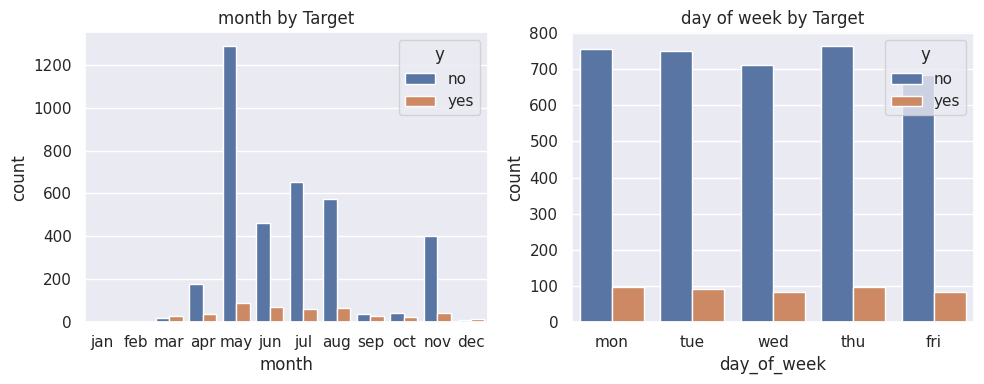

In [242]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

sns.countplot(x='month', hue='y', data=df)
plt.title('month by Target')

plt.subplot(1, 2, 2)
sns.countplot(x='day_of_week', hue='y', data=df)
plt.title('day of week by Target')

plt.tight_layout()
plt.show()

In [243]:
df_agg = df.groupby(['month', 'day_of_week', 'y']).size().reset_index(name='count')
df_agg.head()

,month,day_of_week,y,count
0,jan,mon,no,0
1,jan,mon,yes,0
2,jan,tue,no,0
3,jan,tue,yes,0
4,jan,wed,no,0


In [244]:
fig = go.Figure()

for day in df_agg['day_of_week'].unique():
    data = df_agg[df_agg['day_of_week'] == day]
    fig.add_trace(go.Bar(x=data['month'], y=data['count'], name=day))

fig.update_layout(
    barmode='group',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Count'),
    title='Grouped Bar Chart of Month and Day of Week vs. Target (y)'
)

fig.show()

Duration column

In [245]:
print(df.groupby('y')['duration'].describe())

      count       mean         std   min    25%    50%    75%     max
y                                                                    
no   3668.0  219.40976  198.256347   0.0   96.0  165.0  274.0  3253.0
yes   451.0  560.78714  411.537717  63.0  255.5  458.0  761.0  3643.0


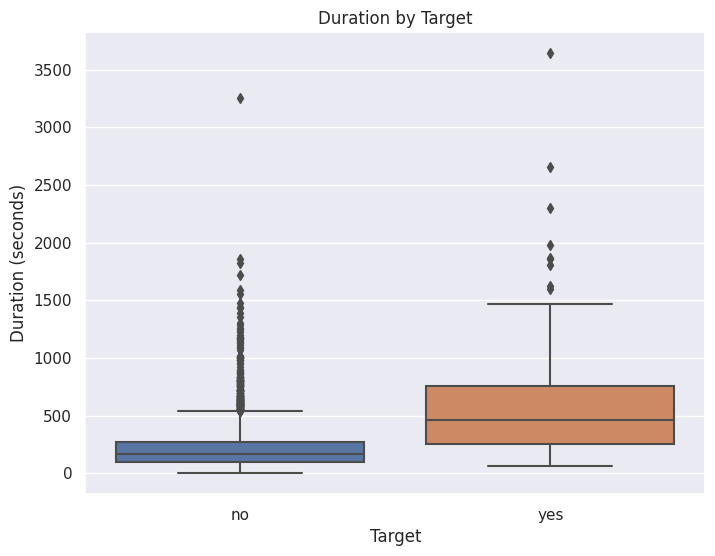

In [246]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='duration', data=df)
plt.title('Duration by Target')
plt.xlabel('Target')
plt.ylabel('Duration (seconds)')
plt.show()

In [247]:
from scipy import stats

duration_yes = df[df['y'] == 'yes']['duration']
duration_no = df[df['y'] == 'no']['duration']
t_stat, p_value = stats.ttest_ind(duration_yes, duration_no)

print(f'T-test statistic: {t_stat}')
print(f'P-value: {p_value}')

# Check the significance level (usually 0.05)
alpha = 0.05
print("There is a significant difference between 'yes' and ' no' groups.") if p_value < alpha else print("There is no significant difference between 'yes' and 'no' groups.")

T-test statistic: 29.57185726364515
P-value: 1.902622447564083e-174
There is a significant difference between 'yes' and ' no' groups.


In [248]:
num_bins = 15 # You can adjust the number of bins as needed
df['duration_category'] = pd.qcut(df['duration'], q=num_bins, labels=False)

# contingency_table = pd.crosstab(df['y'], df['duration_category'])
# chi2, p, _, _= chi2_contingency(contingency_table)

# print(f'Chi-squared statistic: {chi2}')
# print(f'P-value: {p}')

# alpha = 0.05
# print("There is a significant relationship between 'y' and 'duration_category'.") if p < alpha else print("There is no significant relationship between 'y' and 'duration_category'.")

Campaign column

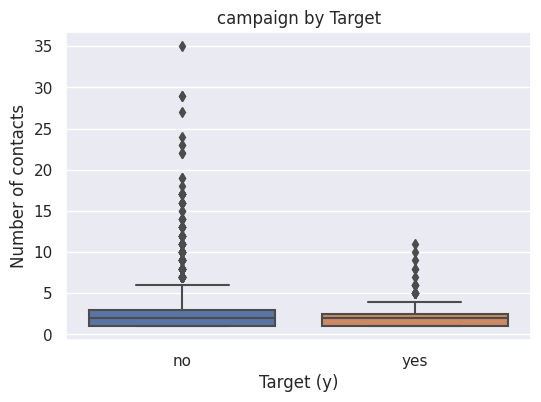

In [249]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='y', y='campaign', data=df)
plt.title(f'campaign by Target')
plt.xlabel('Target (y)')
plt.ylabel('Number of contacts')
plt.show()

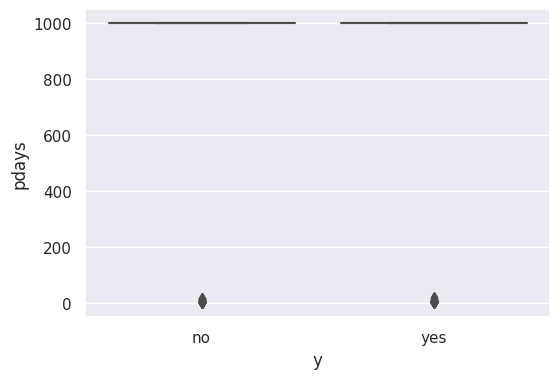

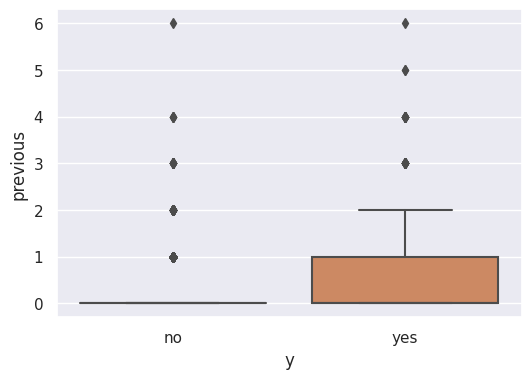

In [250]:
num_feat_01 = ['pdays', 'previous']

for f in num_feat_01:
  plt.figure(figsize=(6, 4))
  sns.boxplot(x=df['y'], y=df[f])
  plt.show()

In [251]:
df.month.value_counts()

may    1378
jul     711
aug     636
jun     530
nov     446
apr     215
oct      69
sep      64
mar      48
dec      22
jan       0
feb       0
Name: month, dtype: int64

In [252]:
df['y_numeric'] = df['y'].map({'yes': 1, 'no': 0}).astype('int')
df['month_numeric'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov':11, 'dec': 12 }).astype('int')

## Pairplot - financial coeff

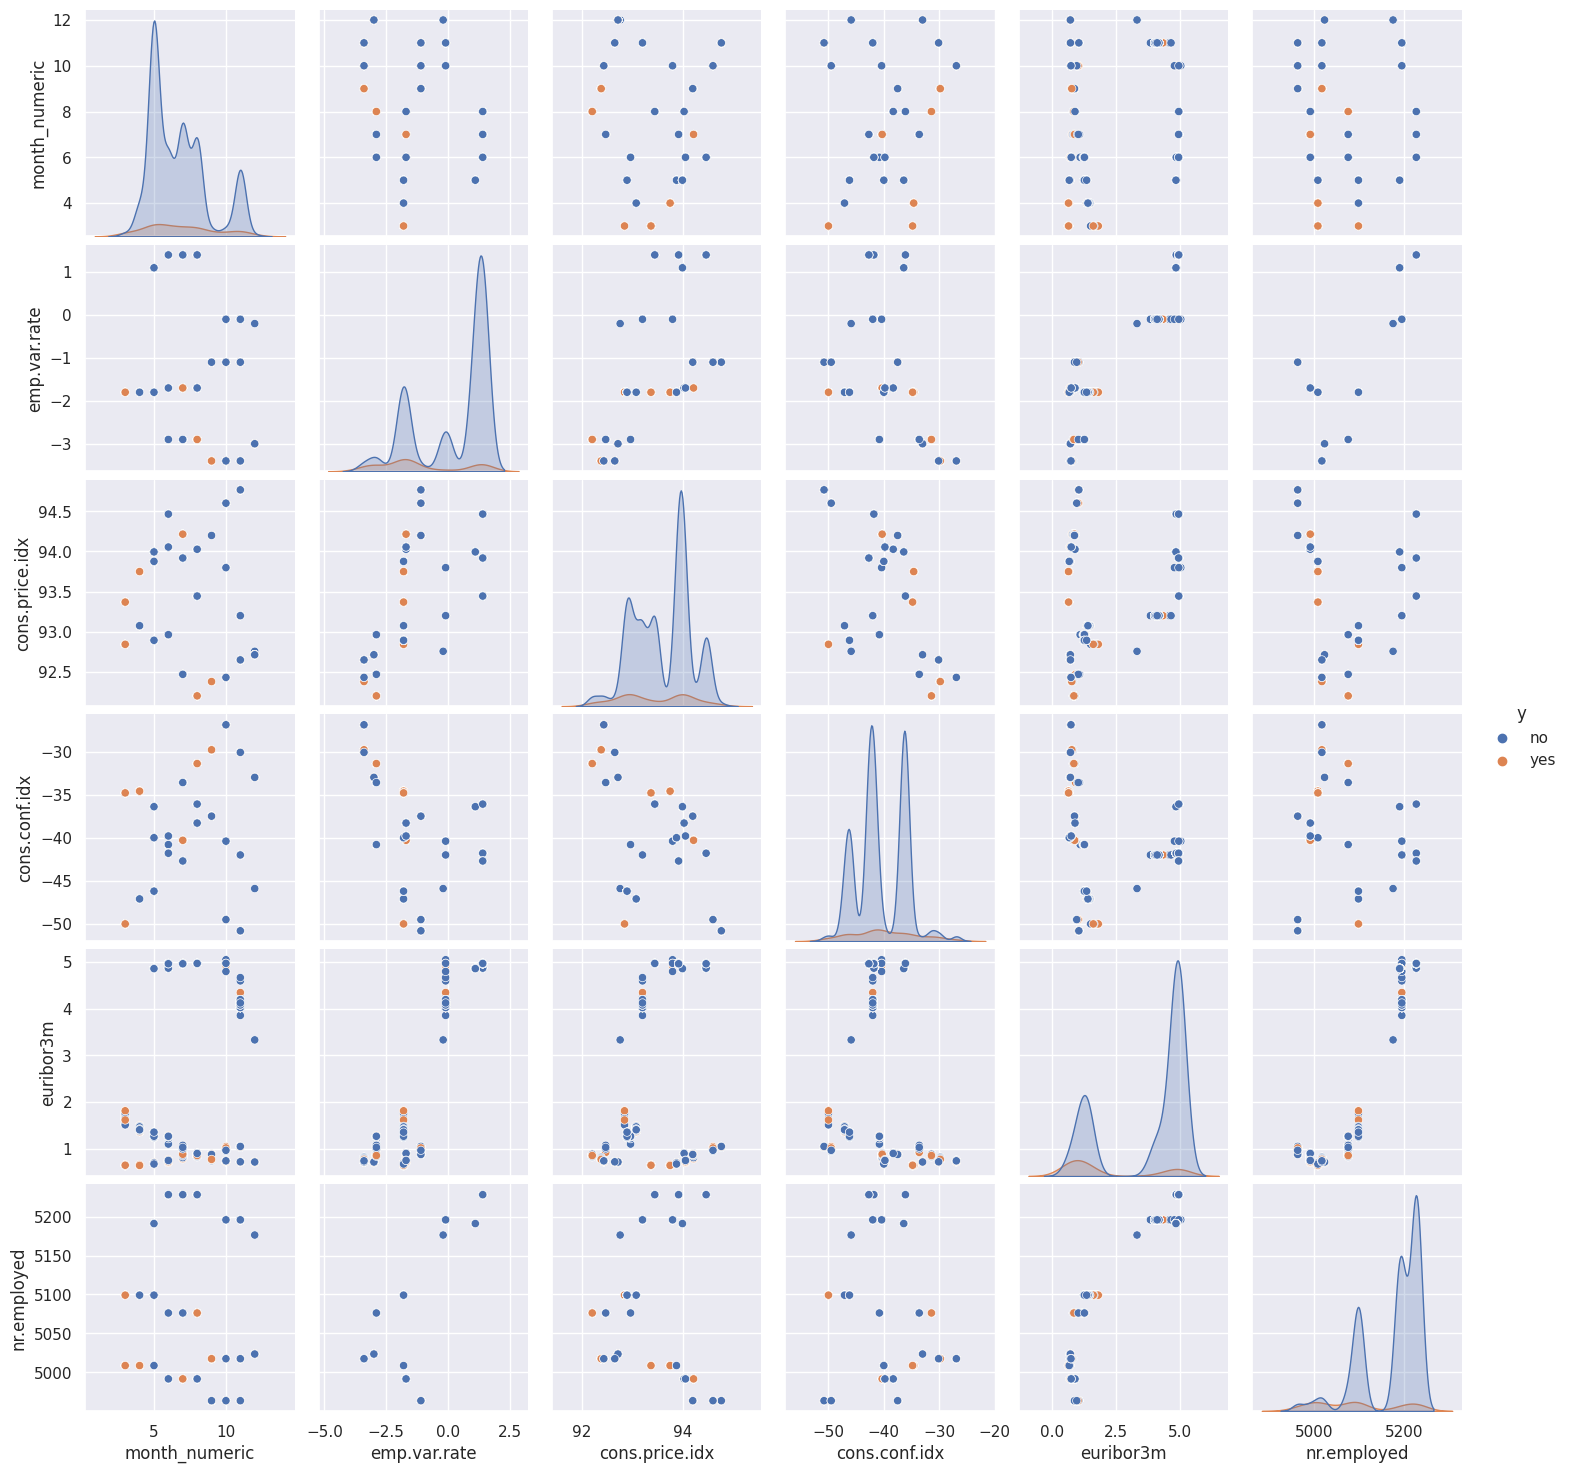

In [253]:
sns.set(rc={"figure.figsize":(32, 12)})

data_coeffs = ['month_numeric', 'emp.var.rate', 'cons.price.idx',  'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']

sns.pairplot(df[data_coeffs], hue="y")

plt.show()

## Relacje pomiędzy zmiennymi w Data Frame

### Wartości numeryczne między sobą

In [254]:
numerical_features=[col for col in df.select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
print(numerical_features)
print(len(numerical_features))
print(type(numerical_features))

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'duration_category', 'month_numeric']
12
<class 'list'>


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, 'age'),
  Text(1.5, 0, 'duration'),
  Text(2.5, 0, 'campaign'),
  Text(3.5, 0, 'pdays'),
  Text(4.5, 0, 'previous'),
  Text(5.5, 0, 'emp.var.rate'),
  Text(6.5, 0, 'cons.price.idx'),
  Text(7.5, 0, 'cons.conf.idx'),
  Text(8.5, 0, 'euribor3m'),
  Text(9.5, 0, 'nr.employed'),
  Text(10.5, 0, 'duration_category'),
  Text(11.5, 0, 'month_numeric')])

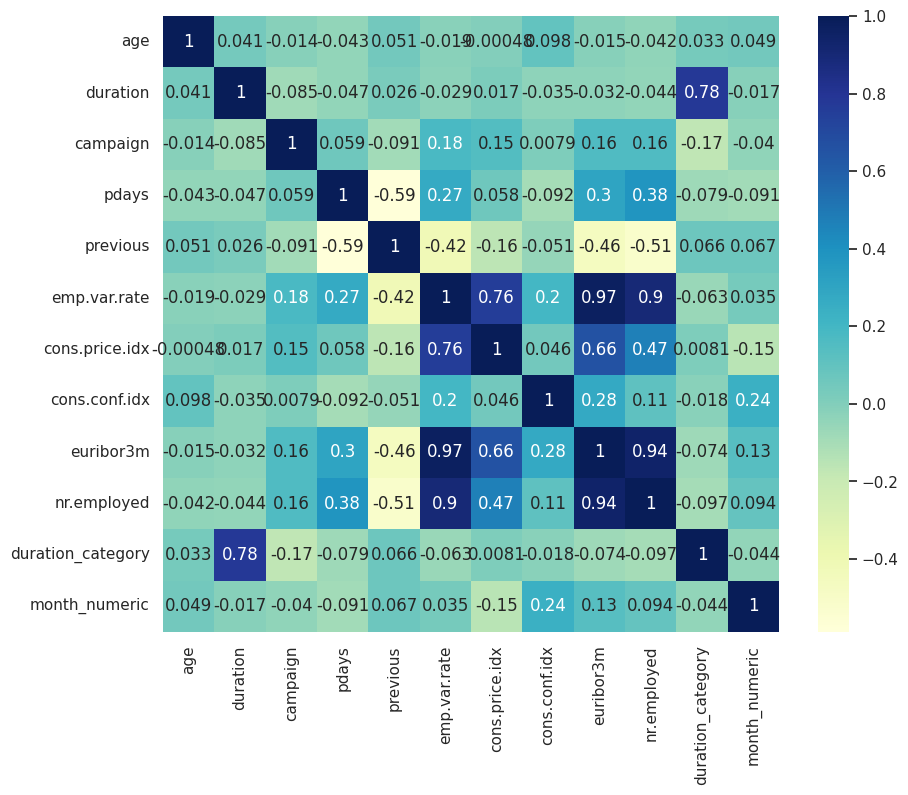

In [255]:
correlations=df[numerical_features].corr()
plt.figure(figsize=(10,8))

sns.heatmap(data=correlations,square=True,annot = True, cmap="YlGnBu")

plt.yticks(rotation=0)
plt.xticks(rotation=90)

In [256]:
# Calculate and display PPS scores for all pairs of numeric variables
for var1 in numerical_features:
    for var2 in numerical_features:
        if var1 != var2:
            pps_score = pps.score(df, var1, var2)['ppscore']
            print(f'PPS Score between {var1} and {var2}: {pps_score:.2f}')

PPS Score between age and duration: 0.00
PPS Score between age and campaign: 0.00
PPS Score between age and pdays: 0.00
PPS Score between age and previous: 0.00
PPS Score between age and emp.var.rate: 0.00
PPS Score between age and cons.price.idx: 0.00
PPS Score between age and cons.conf.idx: 0.00
PPS Score between age and euribor3m: 0.00
PPS Score between age and nr.employed: 0.00
PPS Score between age and duration_category: 0.00
PPS Score between age and month_numeric: 0.00
PPS Score between duration and age: 0.00
PPS Score between duration and campaign: 0.00
PPS Score between duration and pdays: 0.00
PPS Score between duration and previous: 0.00
PPS Score between duration and emp.var.rate: 0.00
PPS Score between duration and cons.price.idx: 0.00
PPS Score between duration and cons.conf.idx: 0.00
PPS Score between duration and euribor3m: 0.00
PPS Score between duration and nr.employed: 0.00
PPS Score between duration and duration_category: 1.00
PPS Score between duration and month_nu

### Wartości numeryczne vs target column

In [257]:
df_copy = df.copy()

In [258]:
df_copy.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duration_category,y_numeric,month_numeric
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,13,0,5
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,11,0,5
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no,9,0,6
3,38,services,married,basic.9y,no,NaN,NaN,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,0,0,6
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,1,0,11


In [259]:
y_numeric = df_copy.pop('y_numeric')

In [260]:
X = df_copy
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duration_category,month_numeric
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,13,5
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,11,5
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no,9,6
3,38,services,married,basic.9y,no,NaN,NaN,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,0,6
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,1,11


In [261]:
X[numerical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                4119 non-null   int64  
 1   duration           4119 non-null   int64  
 2   campaign           4119 non-null   int64  
 3   pdays              4119 non-null   int64  
 4   previous           4119 non-null   int64  
 5   emp.var.rate       4119 non-null   float64
 6   cons.price.idx     4119 non-null   float64
 7   cons.conf.idx      4119 non-null   float64
 8   euribor3m          4119 non-null   float64
 9   nr.employed        4119 non-null   float64
 10  duration_category  4119 non-null   int64  
 11  month_numeric      4119 non-null   int64  
dtypes: float64(5), int64(7)
memory usage: 386.3 KB


In [262]:
y_numeric.info()

<class 'pandas.core.series.Series'>
RangeIndex: 4119 entries, 0 to 4118
Series name: y_numeric
Non-Null Count  Dtype
--------------  -----
4119 non-null   int64
dtypes: int64(1)
memory usage: 32.3 KB


In [263]:
# sprawdzenie korelacji między zmiennymi numerycznymi a targetem ('y_numeric')
for f in numerical_features:
  print(f'\nFeature: {f}')
  print(stats.pointbiserialr(X[f], y_numeric))


Feature: age
SignificanceResult(statistic=0.060374082506977636, pvalue=0.00010569353749626029)

Feature: duration
SignificanceResult(statistic=0.4185653682346244, pvalue=1.9026224475643572e-174)

Feature: campaign
SignificanceResult(statistic=-0.07609088294850745, pvalue=1.0131007149573394e-06)

Feature: pdays
SignificanceResult(statistic=-0.3320115339486591, pvalue=1.442855865352259e-106)

Feature: previous
SignificanceResult(statistic=0.25569662959028744, pvalue=1.725690840999725e-62)

Feature: emp.var.rate
SignificanceResult(statistic=-0.2832156765328247, pvalue=7.822982265332988e-77)

Feature: cons.price.idx
SignificanceResult(statistic=-0.09832603241628189, pvalue=2.5500558703296847e-10)

Feature: cons.conf.idx
SignificanceResult(statistic=0.05439301829399087, pvalue=0.0004786306153979258)

Feature: euribor3m
SignificanceResult(statistic=-0.2985649713595469, pvalue=1.4082264365897354e-85)

Feature: nr.employed
SignificanceResult(statistic=-0.3492412340486664, pvalue=1.84212732949

Zgodnie z informacją w danych - korelacja międzu duration - oraz przetworzoną jej formą duration_category mają dużą korleacją pozytywną ze y - z wuagi na specyfikę zmiennje, będzie później usunięta

## Wizualizacja danych kategorycznych

In [264]:
categorical_features = [col for col in df.select_dtypes(include=['object', 'category']).columns if col != 'y']
print(categorical_features)
print(len(categorical_features))
print(type(categorical_features))

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
10
<class 'list'>


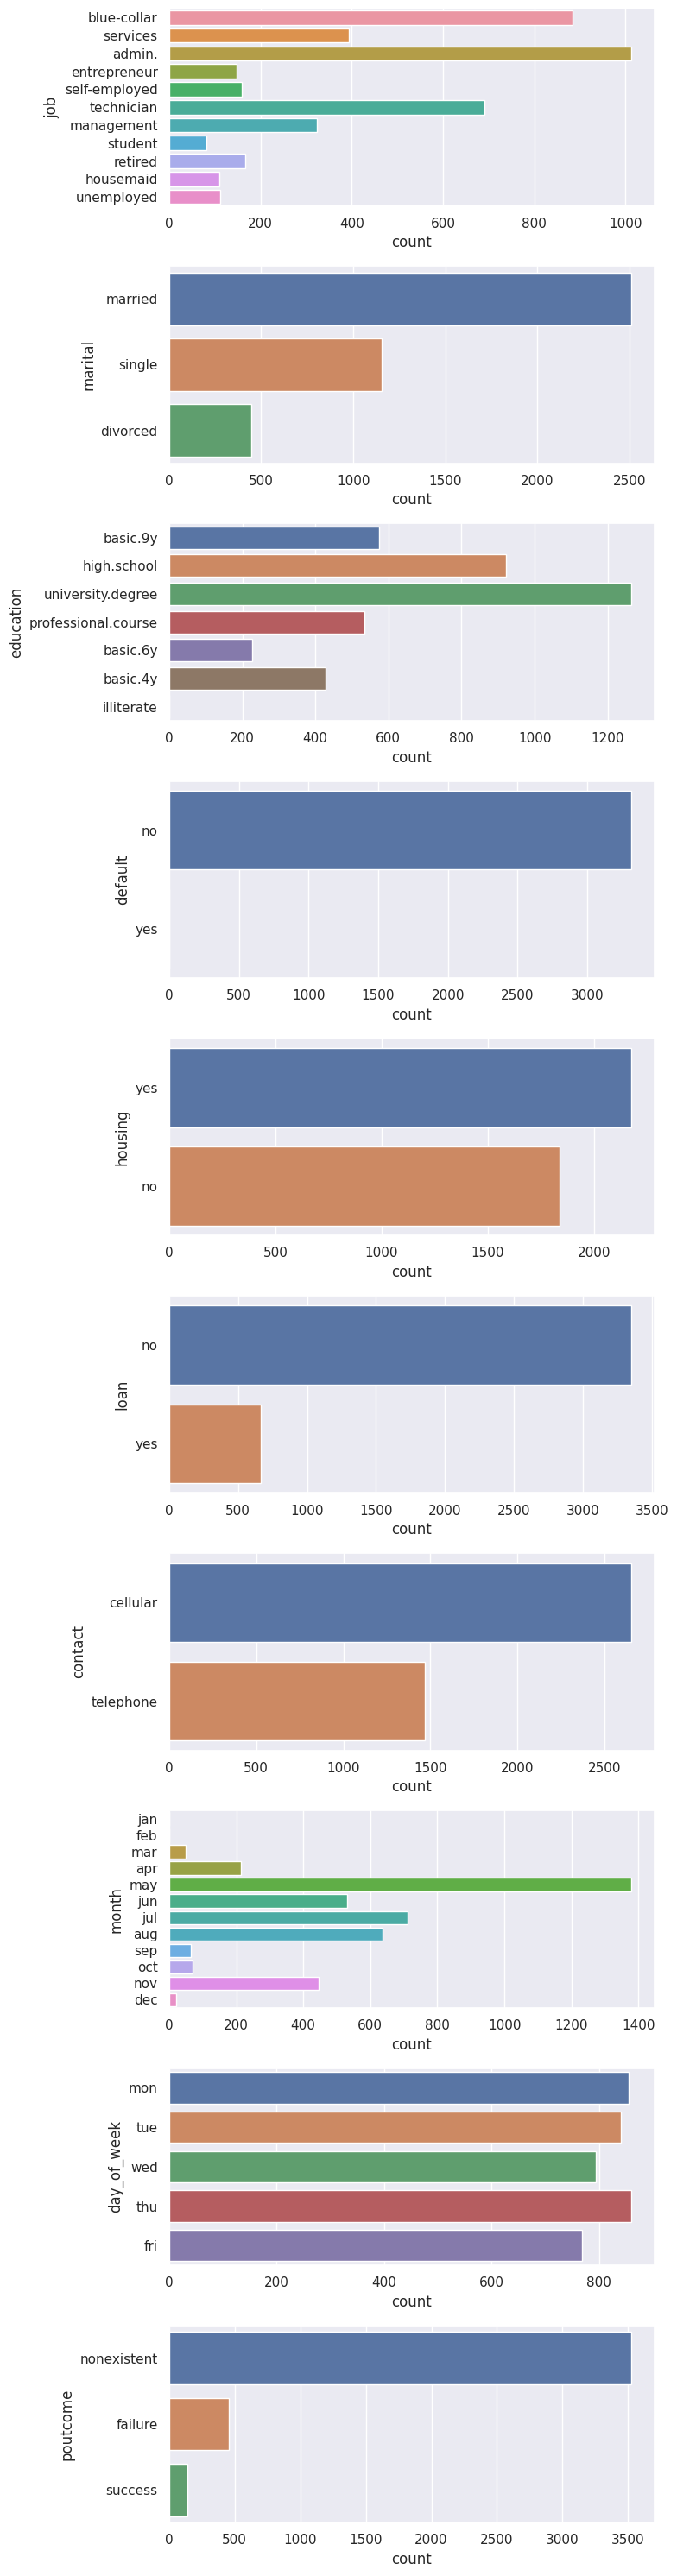

In [265]:
plt.figure(figsize=(8, 30), facecolor='white')

rows = len(categorical_features)
cols = 1

for i, categorical_feature in enumerate(categorical_features, start=1):
    ax = plt.subplot(rows, cols, i)
    sns.countplot(y=categorical_feature, data=df)
    # plt.xlabel(categorical_feature)
    # plt.title(categorical_feature)

plt.tight_layout()

plt.show()

### Sprawdzenie relacji między zmiennymi kategorycznymi oraz targetem za pomconą Information gain w decision tree

In [266]:
target_col = 'y'
target = df[target_col]

df_cat_feat = df[categorical_features]

df_encoded = pd.get_dummies(df_cat_feat, columns=categorical_features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(df_encoded, target, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(criterion='entropy')  # Information Gain criterion
clf.fit(X_train, y_train)

# Get feature importances (information gain)
feature_importance = clf.feature_importances_

# Create a dictionary mapping features to their importance
feature_importance_dict = dict(zip(df_encoded.columns, feature_importance))

# Sort the feature-importance dictionary by information gain
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Print the sorted feature-importance pairs
for feature, info_gain in sorted_feature_importance.items():
    print(f"Feature: {feature}, Information Gain: {info_gain:.4f}")

Feature: poutcome_success, Information Gain: 0.1044
Feature: housing_yes, Information Gain: 0.0769
Feature: day_of_week_wed, Information Gain: 0.0548
Feature: loan_yes, Information Gain: 0.0519
Feature: day_of_week_thu, Information Gain: 0.0433
Feature: job_technician, Information Gain: 0.0403
Feature: day_of_week_fri, Information Gain: 0.0363
Feature: marital_single, Information Gain: 0.0345
Feature: job_management, Information Gain: 0.0342
Feature: day_of_week_tue, Information Gain: 0.0302
Feature: month_jun, Information Gain: 0.0298
Feature: month_aug, Information Gain: 0.0295
Feature: month_jul, Information Gain: 0.0289
Feature: marital_married, Information Gain: 0.0283
Feature: month_may, Information Gain: 0.0280
Feature: contact_telephone, Information Gain: 0.0276
Feature: poutcome_nonexistent, Information Gain: 0.0271
Feature: education_high.school, Information Gain: 0.0265
Feature: job_blue-collar, Information Gain: 0.0253
Feature: job_services, Information Gain: 0.0230
Feature

In summary, the results suggest that 'poutcome_success',  certain day-of-the-week, housing-related, loan features are the most influential in predicting the target variable 'y'.It is possible to use this information to prioritize feature selection or further investigate the relationships between these features and the target variable in your dataset.

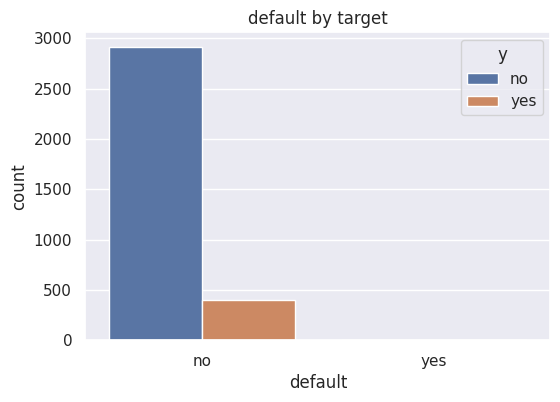

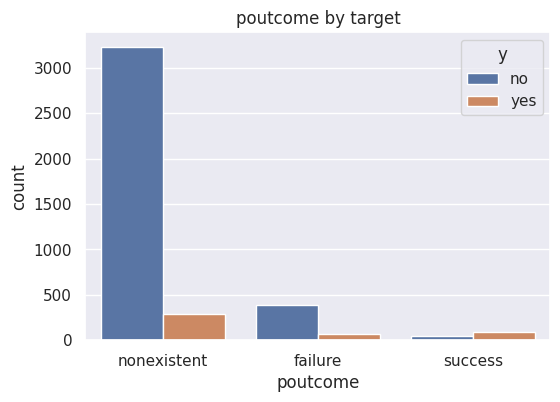

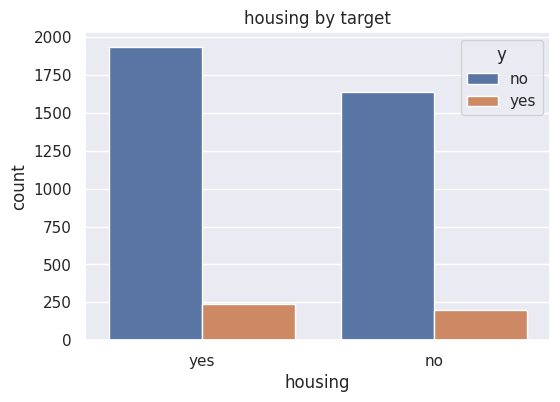

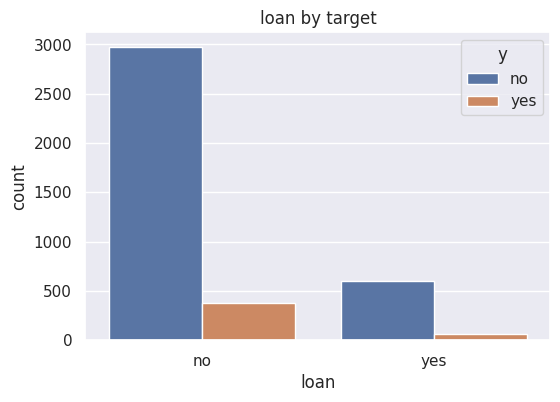

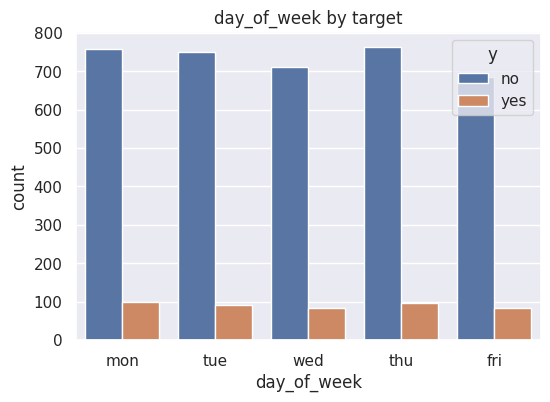

In [267]:
cat_features_vis = ['default', 'poutcome', 'housing', 'loan', 'day_of_week']

for f in cat_features_vis:
  plt.figure(figsize=(6, 4), facecolor='white')
  sns.countplot(x=f, hue='y', data=df)
  print()
  plt.title(f'{f} by target')

## analiza współczynników społecznych / ekonomicznych emp.var.rate', 'cons.price.idx',  'cons.conf.idx', 'euribor3m', 'nr.employed' - dodanie zmiennej year

zmiana wartości euribor na koszyki / pzostałe waartości również zamieniiono w celu łatiwejszej obserwacji zależności oraz wyłapania zmian w poizomach wskaźników.

In [268]:
# Calculate the minimum and maximum values from the DataFrame
min_value_eur = df['euribor3m'].min()
max_value_eur = df['euribor3m'].max()

# Define the bin width
bin_width = 0.5

bins = np.arange(int(min_value_eur), int(max_value_eur) + bin_width, bin_width)

bins = np.linspace(int(min_value_eur), max_value_eur, num_bins + 1)

df['euribor3m_binned'] = pd.cut(df['euribor3m'], bins=bins, labels=bins[:-1])

In [269]:
print(df['euribor3m_binned'])
print(df['euribor3m'])

0       1.009000
1       4.708667
2       4.708667
3       4.708667
4       4.036000
          ...   
4114    4.708667
4115    4.708667
4116    1.345333
4117    4.708667
4118    4.036000
Name: euribor3m_binned, Length: 4119, dtype: category
Categories (15, float64): [0.000000 < 0.336333 < 0.672667 < 1.009000 ... 3.699667 < 4.036000 < 4.372333 <
                           4.708667]
0       1.313
1       4.855
2       4.962
3       4.959
4       4.191
        ...  
4114    4.958
4115    4.959
4116    1.354
4117    4.966
4118    4.120
Name: euribor3m, Length: 4119, dtype: float64


In [270]:
len(df['euribor3m_binned'].unique())

10

In [271]:
numerical_features.append('euribor3m_binned')

In [272]:
for column in df[numerical_features]:
    unique_values = df[column].unique()
    print(f"Unique values in column {column}: {', '.join(map(str, unique_values))}")

Unique values in column age: 30, 39, 25, 38, 47, 32, 41, 31, 35, 36, 29, 27, 44, 46, 45, 50, 55, 40, 28, 34, 33, 51, 48, 20, 76, 56, 24, 58, 60, 37, 52, 42, 49, 54, 59, 57, 43, 53, 75, 82, 71, 21, 22, 23, 26, 81, 61, 67, 73, 18, 64, 74, 77, 86, 85, 63, 88, 78, 72, 68, 80, 66, 19, 62, 65, 69, 70
Unique values in column duration: 487, 346, 227, 17, 58, 128, 290, 44, 68, 170, 301, 148, 97, 211, 553, 698, 191, 59, 38, 849, 326, 222, 626, 119, 388, 479, 446, 127, 109, 113, 393, 151, 256, 42, 525, 57, 499, 84, 137, 31, 430, 126, 340, 412, 132, 79, 341, 157, 252, 263, 215, 89, 143, 40, 10, 481, 233, 204, 403, 180, 16, 447, 81, 361, 1091, 395, 432, 596, 77, 768, 96, 357, 459, 11, 264, 93, 374, 158, 95, 835, 505, 300, 390, 274, 135, 257, 268, 477, 91, 76, 103, 436, 483, 250, 259, 389, 7, 123, 92, 297, 406, 104, 854, 147, 203, 149, 144, 394, 523, 73, 197, 108, 80, 114, 122, 1161, 181, 239, 360, 314, 984, 663, 141, 706, 797, 311, 63, 111, 49, 171, 242, 279, 246, 309, 168, 153, 152, 90, 117, 640, 

In [273]:
columns_coeff = ['emp.var.rate', 'cons.price.idx',  'cons.conf.idx', 'euribor3m', 'nr.employed', 'euribor3m_binned']

value_mappings = {}

for column in df[columns_coeff]:
    unique_values = df[column].unique()
    value_mapping = {value: i + 1 for i, value in enumerate(unique_values)}
    value_mappings[column] = value_mapping

for column in df[columns_coeff]:
    new_column_name = f"{column}_updated"
    df[new_column_name] = df[column].map(value_mappings[column])

print(df)

      age          job  marital          education default housing loan  \
0      30  blue-collar  married           basic.9y      no     yes   no   
1      39     services   single        high.school      no      no   no   
2      25     services  married        high.school      no     yes   no   
3      38     services  married           basic.9y      no     NaN  NaN   
4      47       admin.  married  university.degree      no     yes   no   
...   ...          ...      ...                ...     ...     ...  ...   
4114   30       admin.  married           basic.6y      no     yes  yes   
4115   39       admin.  married        high.school      no     yes   no   
4116   27      student   single        high.school      no      no   no   
4117   58       admin.  married        high.school      no      no   no   
4118   34   management   single        high.school      no     yes   no   

        contact month day_of_week  duration  campaign  pdays  previous  \
0      cellular   may    

Przyporządkowanie roku wierszom na bazie innych danych - 'euribor3m' oraz kolumny 'month' i reszty istniejących kolumn, analziaując ich zmiany oraz poównując z wartościami rzeczywistaymi (euribor3m) - na bazie zmian wre wskaźnikach można jednoznacznie określić year i month wystąpienia (nie dokładny dzień)

In [274]:
conditions = [
    (df['euribor3m'] > 2.892),
    (df['euribor3m'] > 1.05),
    (df['month_numeric'] == 12),
    ((df['month_numeric'] >= 3) & (df['month_numeric'] <= 6)),
    ((df['month_numeric'] == 7) & (df['nr.employed_updated'] == 7)), # wybieramy lipiec 2009 z wszystkich danych lipcowych
    ((df['month_numeric'] == 8) & (df['nr.employed_updated'] == 7)),
    ((df['month_numeric'] == 9) & (df['nr.employed_updated'] == 9)),
    ((df['month_numeric'] == 10) & (df['nr.employed_updated'] == 9)),
    ((df['month_numeric'] == 11) & (df['nr.employed_updated'] == 9))
]
choices = ['2008', '2009', '2009', '2010', '2009', '2009','2009', '2009', '2009']

df['year'] = pd.np.select(conditions, choices, default='2010')

In [275]:
# dtale.show(df)

### visualization column results for variable 'y' (0/1 binary column) with distribution in month (feature) and year (feature) on 1 chart.

In [276]:
df.groupby(['year', 'month_numeric'])['y_numeric'].count().unstack()

month_numeric,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,
2008,NaN,NaN,758.0,431.0,667.0,528.0,NaN,6.0,386.0,1.0
2009,25.0,201.0,597.0,75.0,14.0,75.0,25.0,43.0,36.0,21.0
2010,23.0,14.0,23.0,24.0,30.0,33.0,39.0,20.0,24.0,NaN


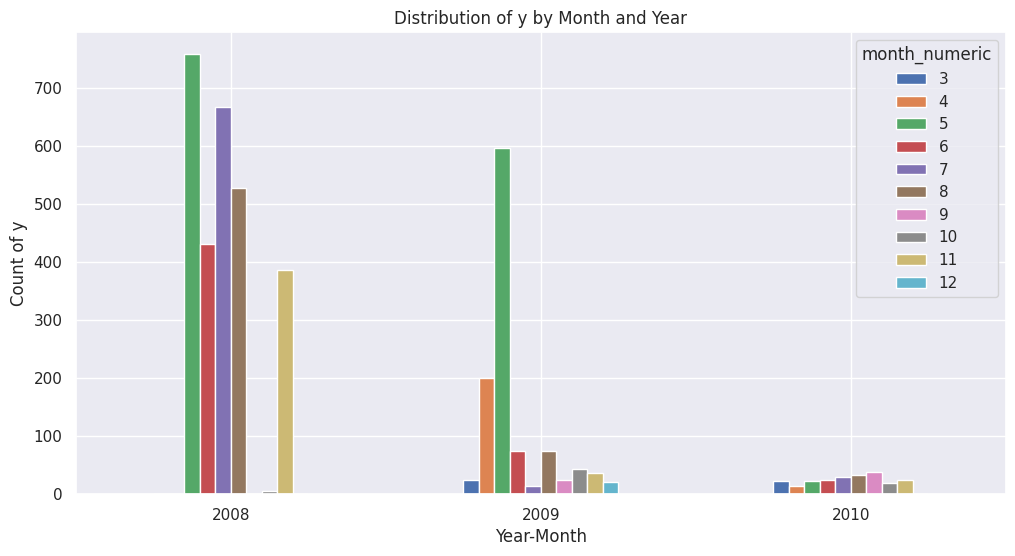

In [277]:
result = df.groupby(['year', 'month_numeric'])['y'].count().unstack(fill_value=0)

result.plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of y by Month and Year')
plt.xlabel('Year-Month')
plt.ylabel('Count of y')
plt.legend(title='month_numeric')
plt.xticks(rotation=0)
plt.show()

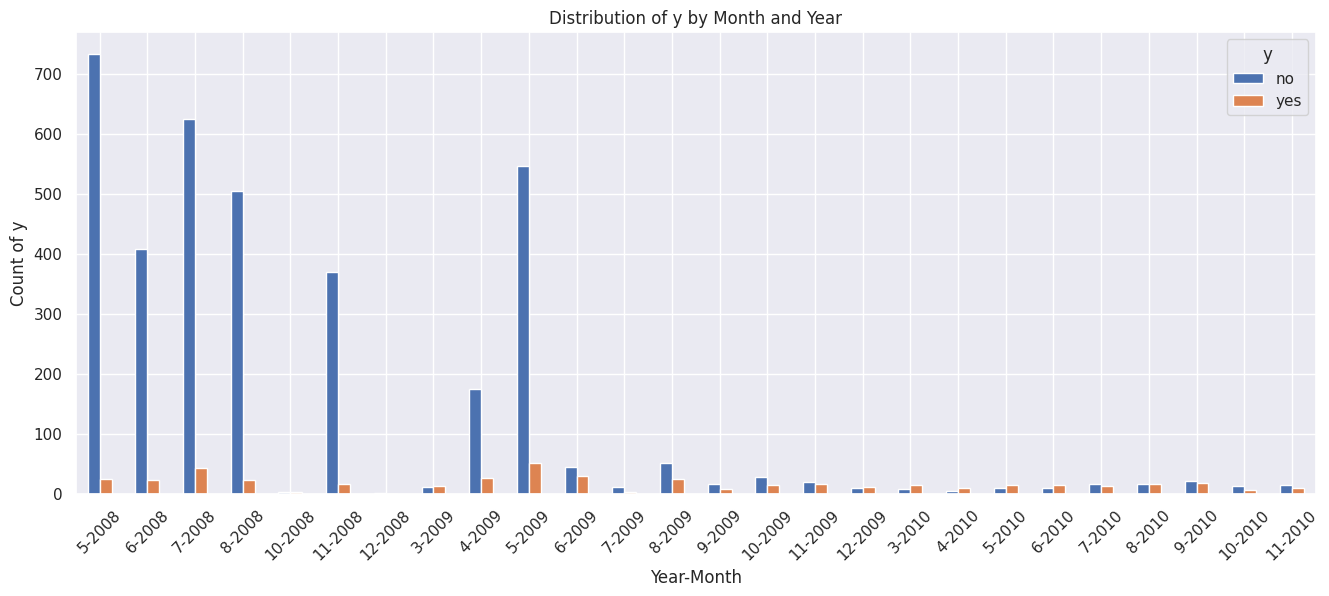

In [278]:
result = df.groupby(['year', 'month_numeric', 'y'])['y'].count().unstack(fill_value=0)

# Create a list of labels with year below each group of months
x_labels = [f"{month}-{year}" for (year, month) in result.index]

# Plot the results as a bar chart
fig, ax = plt.subplots(figsize=(16, 6))  # Extend the width of the chart
result.plot(kind='bar', ax=ax)

# Set x-axis labels (grouping months by year)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)

plt.title('Distribution of y by Month and Year')
plt.xlabel('Year-Month')
plt.ylabel('Count of y')
plt.legend(title='y')
plt.xticks(rotation=45)
plt.show()

In [279]:
df['month_object'] = df['month'].astype(str)

In [280]:
# łączenie kolumn month and w jedną kolumnę
df['month_year'] = df['month_object'] + '_' + df['year'].astype('str')
df['month_year'] = df['month_year'].astype('category')

In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       4119 non-null   int64   
 1   job                       4080 non-null   object  
 2   marital                   4108 non-null   object  
 3   education                 3952 non-null   object  
 4   default                   3316 non-null   object  
 5   housing                   4014 non-null   object  
 6   loan                      4014 non-null   object  
 7   contact                   4119 non-null   object  
 8   month                     4119 non-null   category
 9   day_of_week               4119 non-null   category
 10  duration                  4119 non-null   int64   
 11  campaign                  4119 non-null   int64   
 12  pdays                     4119 non-null   int64   
 13  previous                  4119 non-null   int64 

In [282]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duration_category,y_numeric,month_numeric,euribor3m_binned,emp.var.rate_updated,cons.price.idx_updated,cons.conf.idx_updated,euribor3m_updated,nr.employed_updated,euribor3m_binned_updated,year,month_object,month_year
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,13,0,5,1.009000,1,1,1,1,1,1.0,2009,may,may_2009
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,11,0,5,4.708667,2,2,2,2,2,2.0,2008,may,may_2008
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no,9,0,6,4.708667,3,3,3,3,3,2.0,2008,jun,jun_2008
3,38,services,married,basic.9y,no,NaN,NaN,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,0,0,6,4.708667,3,3,3,4,3,2.0,2008,jun,jun_2008
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,1,0,11,4.036000,4,4,4,5,4,3.0,2008,nov,nov_2008


# Data Preprocessing

## Wartości null

Łącznie mamy 1029 wierszy z wartościami null (niektóre w kilku kolumnach)
Dla 5 kolumn kategorycznych  wartości nulls są zdecydowaną mniejszością (od 1% od 4% wierszy) - dla nich uzupełnię nulle wartością zmiennej najczęście spotykaną.
Dla Kolumny 'default' aż 803 rekordy (19%) stanowią wartości null - będzie później usunięta.

In [283]:
df['job'].fillna(df['job'].mode()[0], inplace=True)
df['marital'].fillna(df['marital'].mode()[0], inplace=True)
df['education'].fillna(df['education'].mode()[0], inplace=True)
df['housing'].fillna(df['housing'].mode()[0], inplace=True)
df['loan'].fillna(df['loan'].mode()[0], inplace=True)

In [284]:
df.isnull().sum()

age                           0
job                           0
marital                       0
education                     0
default                     803
housing                       0
loan                          0
contact                       0
month                         0
day_of_week                   0
duration                      0
campaign                      0
pdays                         0
previous                      0
poutcome                      0
emp.var.rate                  0
cons.price.idx                0
cons.conf.idx                 0
euribor3m                     0
nr.employed                   0
y                             0
duration_category             0
y_numeric                     0
month_numeric                 0
euribor3m_binned              0
emp.var.rate_updated          0
cons.price.idx_updated        0
cons.conf.idx_updated         0
euribor3m_updated             0
nr.employed_updated           0
euribor3m_binned_updated      0
year    

Strukura kolumny 'default', nie pozwala jej wziąć do modelowania - tylko 1 wartośći z kategorii 'yes', 1/5 wartości to nulls, nie zależy również od informacji w innych kolumnach

In [285]:
df['default'].value_counts()

no     3315
yes       1
Name: default, dtype: int64

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       4119 non-null   int64   
 1   job                       4119 non-null   object  
 2   marital                   4119 non-null   object  
 3   education                 4119 non-null   object  
 4   default                   3316 non-null   object  
 5   housing                   4119 non-null   object  
 6   loan                      4119 non-null   object  
 7   contact                   4119 non-null   object  
 8   month                     4119 non-null   category
 9   day_of_week               4119 non-null   category
 10  duration                  4119 non-null   int64   
 11  campaign                  4119 non-null   int64   
 12  pdays                     4119 non-null   int64   
 13  previous                  4119 non-null   int64 

## Podział danych na zbiór treningowy i testowy

In [287]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duration_category,y_numeric,month_numeric,euribor3m_binned,emp.var.rate_updated,cons.price.idx_updated,cons.conf.idx_updated,euribor3m_updated,nr.employed_updated,euribor3m_binned_updated,year,month_object,month_year
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,13,0,5,1.009000,1,1,1,1,1,1.0,2009,may,may_2009
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,11,0,5,4.708667,2,2,2,2,2,2.0,2008,may,may_2008
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no,9,0,6,4.708667,3,3,3,3,3,2.0,2008,jun,jun_2008
3,38,services,married,basic.9y,no,yes,no,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,0,0,6,4.708667,3,3,3,4,3,2.0,2008,jun,jun_2008
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,1,0,11,4.036000,4,4,4,5,4,3.0,2008,nov,nov_2008



* w listach zapisane zmienne zmienne do późniejszego modelowania
* zmienna duration nie moze brać udział w trnowaniu danych - długośź połączenia nie jest znana przed jego wykonaniem, zatem przy liście zmiennych pomijamy zmienną 'duration'

### Zestaw danych nr 1

In [288]:
model_columns = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
      'y_numeric']

print(len(model_columns))
print(model_columns)

19
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y_numeric']


In [289]:
data = df[model_columns]
y = data.pop('y_numeric')
y

0       0
1       0
2       0
3       0
4       0
       ..
4114    0
4115    0
4116    0
4117    0
4118    0
Name: y_numeric, Length: 4119, dtype: int64

In [290]:
X = data
X.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,30,blue-collar,married,basic.9y,yes,no,cellular,may,fri,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1
1,39,services,single,high.school,no,no,telephone,may,fri,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
2,25,services,married,high.school,yes,no,telephone,jun,wed,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1
3,38,services,married,basic.9y,yes,no,telephone,jun,fri,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
4,47,admin.,married,university.degree,yes,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


In [291]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             4119 non-null   int64   
 1   job             4119 non-null   object  
 2   marital         4119 non-null   object  
 3   education       4119 non-null   object  
 4   housing         4119 non-null   object  
 5   loan            4119 non-null   object  
 6   contact         4119 non-null   object  
 7   month           4119 non-null   category
 8   day_of_week     4119 non-null   category
 9   campaign        4119 non-null   int64   
 10  pdays           4119 non-null   int64   
 11  previous        4119 non-null   int64   
 12  poutcome        4119 non-null   object  
 13  emp.var.rate    4119 non-null   float64 
 14  cons.price.idx  4119 non-null   float64 
 15  cons.conf.idx   4119 non-null   float64 
 16  euribor3m       4119 non-null   float64 
 17  nr.employed   

In [292]:
num_feat = [col for col in df[model_columns].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']

cat_feat = [col for col in df[model_columns].select_dtypes(include=['object']).columns if col != 'y']

ord_feat = [col for col in df[model_columns].select_dtypes(include=['category']).columns if col != 'y']

print(f'No. of numerical features: {len(num_feat)}')
print(num_feat)
print()
print(f'No. of categorical features: {len(cat_feat)}')
print(cat_feat)
print()
print(f'No. of ordinal features: {len(ord_feat)}')
print(ord_feat)

No. of numerical features: 9
['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

No. of categorical features: 7
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

No. of ordinal features: 2
['month', 'day_of_week']


In [293]:
# ord_feat = [col for col in df[model_columns].select_dtypes(include=['category']).columns if col != 'y']

In [294]:
# ord_feat

In [295]:
seed = 23

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [297]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3295, 18), (3295,), (824, 18), (824,))

In [298]:
y_train.value_counts()

0    2934
1     361
Name: y_numeric, dtype: int64

In [299]:
361 / (2934+361)

0.10955993930197269

In [300]:
y_test.value_counts()

0    734
1     90
Name: y_numeric, dtype: int64

## Feature Importance - RandomForestClassifier() - Zestaw danych nr 1

In [301]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat),
        ('ordinal', ordinal_transformer, ord_feat)
    ]
)

rfc_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model', RandomForestClassifier(random_state=seed))])

In [302]:
rfc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x79c4005a5d50>)]),
                                                  ['month', 'day_of_week'])])),
                ('rfc_model', RandomForestClassifier(random_state=23))])

In [303]:
feature_importance = rfc_pipeline.steps[-1][1].feature_importances_
all_column_names = X_train.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance: 

 age: 0.0268677584108947
 poutcome: 0.025710206691869675
 nr.employed: 0.024363048548194467
 emp.var.rate: 0.02428816364519069
 campaign: 0.02416070739269782
 month: 0.01751885007002464
 previous: 0.01726601742629355
 housing: 0.016861064168508327
 cons.price.idx: 0.01682548211672266
 job: 0.016700213012565614
 euribor3m: 0.01509328610188216
 loan: 0.014197137471708523
 pdays: 0.01143889857022313
 day_of_week: 0.01107454530846042
 cons.conf.idx: 0.009423281621242379
 contact: 0.00886578907181938
 marital: 0.007176347141683523
 education: 0.006912994859478684


### Zestaw danych nr 2

z nowo stworzoną zmienną month_year oraz wybranym 1 z 5 wskaźników finansowych  wuagi na ich wysoką kolerację i wspólne zależności (ppsscore) )

In [304]:
model_columns_2 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
        'emp.var.rate', 'month_year',
        'y_numeric']

print(len(model_columns_2))
print(model_columns_2)

15
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'month_year', 'y_numeric']


In [305]:
data_2 = df[model_columns_2]

In [306]:
y_2 = data_2.pop('y_numeric')
y_2

0       0
1       0
2       0
3       0
4       0
       ..
4114    0
4115    0
4116    0
4117    0
4118    0
Name: y_numeric, Length: 4119, dtype: int64

In [307]:
X_2 = data_2
X_2.head()

,age,job,marital,education,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,month_year
0,30,blue-collar,married,basic.9y,yes,no,cellular,fri,2,999,0,nonexistent,-1.8,may_2009
1,39,services,single,high.school,no,no,telephone,fri,4,999,0,nonexistent,1.1,may_2008
2,25,services,married,high.school,yes,no,telephone,wed,1,999,0,nonexistent,1.4,jun_2008
3,38,services,married,basic.9y,yes,no,telephone,fri,3,999,0,nonexistent,1.4,jun_2008
4,47,admin.,married,university.degree,yes,no,cellular,mon,1,999,0,nonexistent,-0.1,nov_2008


In [308]:
num_feat_2 = [col for col in df[model_columns_2].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_2 = [col for col in df[model_columns_2].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_2 = [col for col in df[model_columns_2].select_dtypes(include=['category']).columns if col != 'y']
print(f'No. of numerical features: {len(num_feat_2)}')
print(num_feat_2)
print()
print(f'No. of categorical features: {len(cat_feat_2)}')
print(cat_feat_2)
print()
print(f'No. of ordinal features: {len(ord_feat_2)}')
print(ord_feat_2)

No. of numerical features: 5
['age', 'campaign', 'pdays', 'previous', 'emp.var.rate']

No. of categorical features: 7
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

No. of ordinal features: 2
['day_of_week', 'month_year']


In [309]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=seed, stratify=y)

In [310]:
X_train_2.shape, y_train_2.shape, X_test_2.shape, y_test_2.shape

((3295, 14), (3295,), (824, 14), (824,))

In [311]:
y_train_2.value_counts()

0    2934
1     361
Name: y_numeric, dtype: int64

In [312]:
361 / (2934+361)

0.10955993930197269

In [313]:
y_test_2.value_counts()

0    734
1     90
Name: y_numeric, dtype: int64

In [314]:
90 / (734+90)

0.10922330097087378

## Feature Importance - RandomForestClassifier() - Zestaw danych nr 2

In [315]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_2),
        ('ordinal', ordinal_transformer, ord_feat_2)
    ]
)

rfc_pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_2', RandomForestClassifier(random_state=seed))])

In [316]:
rfc_pipeline_2.fit(X_train_2, y_train_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x79c3ff81e7d0>)]),
                                                  ['day_of_week',
                                                   'month_year'])])),
                ('rfc_model_2', RandomForestClassifier(random_state=23))])

In [317]:
feature_importance = rfc_pipeline_2.steps[-1][1].feature_importances_
all_column_names = X_train_2.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 2: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance - zestaw danych 2: 

 age: 0.02591324001424403
 pdays: 0.02250008347873538
 emp.var.rate: 0.022331282777275828
 month_year: 0.0216472729054858
 day_of_week: 0.015419510063230417
 poutcome: 0.015312653130634067
 job: 0.015078911783612783
 housing: 0.015031408708265508
 loan: 0.013982861894174145
 previous: 0.010637547511346697
 campaign: 0.009908147031313225
 contact: 0.007912279402230486
 marital: 0.0066016848640053985
 education: 0.006427581316993075


In [318]:
# stop

### Zestaw danych 3

-  pozostawiono 2 zmienne społeczono - ekonomiczne wybrane ze względu na ich istotność (oraz niższy niż inne skorelowanie)

In [319]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,duration_category,y_numeric,month_numeric,euribor3m_binned,emp.var.rate_updated,cons.price.idx_updated,cons.conf.idx_updated,euribor3m_updated,nr.employed_updated,euribor3m_binned_updated,year,month_object,month_year
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no,13,0,5,1.009000,1,1,1,1,1,1.0,2009,may,may_2009
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no,11,0,5,4.708667,2,2,2,2,2,2.0,2008,may,may_2008
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no,9,0,6,4.708667,3,3,3,3,3,2.0,2008,jun,jun_2008
3,38,services,married,basic.9y,no,yes,no,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,0,0,6,4.708667,3,3,3,4,3,2.0,2008,jun,jun_2008
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,1,0,11,4.036000,4,4,4,5,4,3.0,2008,nov,nov_2008


In [320]:
model_columns_3 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
        'month', 'cons.conf.idx', 'emp.var.rate',
        'y_numeric']

print(len(model_columns_3))
print(model_columns_3)

16
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'month', 'cons.conf.idx', 'emp.var.rate', 'y_numeric']


In [321]:
data_3 = df[model_columns_3]

y_3 = data_3.pop('y_numeric')
y_3

0       0
1       0
2       0
3       0
4       0
       ..
4114    0
4115    0
4116    0
4117    0
4118    0
Name: y_numeric, Length: 4119, dtype: int64

In [322]:
X_3 = data_3
X_3.head()

,age,job,marital,education,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,month,cons.conf.idx,emp.var.rate
0,30,blue-collar,married,basic.9y,yes,no,cellular,fri,2,999,0,nonexistent,may,-46.2,-1.8
1,39,services,single,high.school,no,no,telephone,fri,4,999,0,nonexistent,may,-36.4,1.1
2,25,services,married,high.school,yes,no,telephone,wed,1,999,0,nonexistent,jun,-41.8,1.4
3,38,services,married,basic.9y,yes,no,telephone,fri,3,999,0,nonexistent,jun,-41.8,1.4
4,47,admin.,married,university.degree,yes,no,cellular,mon,1,999,0,nonexistent,nov,-42.0,-0.1


In [323]:
num_feat_3 = [col for col in df[model_columns_3].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_3 = [col for col in df[model_columns_3].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_3 = [col for col in df[model_columns_3].select_dtypes(include=['category']).columns if col != 'y']
print(f'No. of numerical features: {len(num_feat_3)}')
print(num_feat_3)
print()
print(f'No. of categorical features: {len(cat_feat_3)}')
print(cat_feat_3)
print()
print(f'No. of ordinal features: {len(ord_feat_3)}')
print(ord_feat_3)

No. of numerical features: 6
['age', 'campaign', 'pdays', 'previous', 'cons.conf.idx', 'emp.var.rate']

No. of categorical features: 7
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

No. of ordinal features: 2
['day_of_week', 'month']


In [324]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=seed, stratify=y)

X_train_3.shape, y_train_3.shape, X_test_3.shape, y_test_3.shape

((3295, 15), (3295,), (824, 15), (824,))

In [325]:
print(y_train_3.value_counts())

0    2934
1     361
Name: y_numeric, dtype: int64


In [326]:
print(y_test_3.value_counts())

0    734
1     90
Name: y_numeric, dtype: int64


## Feature Importance - RandomForestClassifier() - Zestaw danych nr 3

In [327]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_3),
        ('ordinal', ordinal_transformer, ord_feat_3)
    ]
)

rfc_pipeline_3 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_3', RandomForestClassifier(random_state=seed))])

In [328]:
rfc_pipeline_3.fit(X_train_3, y_train_3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x79c3ff650220>)]),
                                                  ['day_of_week', 'month'])])),
                ('rfc_model_3', RandomForestClassifier(random_state=23))])

In [329]:
feature_importance = rfc_pipeline_3.steps[-1][1].feature_importances_
all_column_names = X_train_3.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 3: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance - zestaw danych 3: 

 age: 0.026123649498428925
 month: 0.024464120922559097
 cons.conf.idx: 0.023607166324329857
 pdays: 0.0231554581617383
 day_of_week: 0.0184142336554891
 housing: 0.016860328940924436
 poutcome: 0.01674457027654782
 job: 0.016482780768810597
 emp.var.rate: 0.01637145362741636
 loan: 0.014670891400417241
 campaign: 0.011134838766105574
 previous: 0.010459259207218184
 contact: 0.009389739970860846
 education: 0.007443469967620293
 marital: 0.00628507598971507


### Zestaw danych 4

- mix 2 i 3 zestawu - month_year zostawiony +  pozostawiono 2 zmienne społeczono - ekonomiczne wybrane ze względu na ich istotność (2, które mają najniższą korelację i wpły na siebie)

In [347]:
model_columns_4 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.conf.idx', 'month_year',
        'y_numeric']

In [348]:
print(len(model_columns_4))
print(model_columns_4)

16
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.conf.idx', 'month_year', 'y_numeric']


In [349]:
data_4 = df[model_columns_4]

In [350]:
y_4 = data_4.pop('y_numeric')
y_4

0       0
1       0
2       0
3       0
4       0
       ..
4114    0
4115    0
4116    0
4117    0
4118    0
Name: y_numeric, Length: 4119, dtype: int64

In [351]:
X_4 = data_4
X_4.head()

,age,job,marital,education,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.conf.idx,month_year
0,30,blue-collar,married,basic.9y,yes,no,cellular,fri,2,999,0,nonexistent,-1.8,-46.2,may_2009
1,39,services,single,high.school,no,no,telephone,fri,4,999,0,nonexistent,1.1,-36.4,may_2008
2,25,services,married,high.school,yes,no,telephone,wed,1,999,0,nonexistent,1.4,-41.8,jun_2008
3,38,services,married,basic.9y,yes,no,telephone,fri,3,999,0,nonexistent,1.4,-41.8,jun_2008
4,47,admin.,married,university.degree,yes,no,cellular,mon,1,999,0,nonexistent,-0.1,-42.0,nov_2008


In [352]:
num_feat_4 = [col for col in df[model_columns_4].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_4 = [col for col in df[model_columns_4].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_4 = [col for col in df[model_columns_4].select_dtypes(include=['category']).columns if col != 'y']
print(f'No. of numerical features: {len(num_feat_4)}')
print(num_feat_4)
print()
print(f'No. of categorical features: {len(cat_feat_4)}')
print(cat_feat_4)
print()
print(f'No. of ordinal features: {len(ord_feat_4)}')
print(ord_feat_4)

No. of numerical features: 6
['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.conf.idx']

No. of categorical features: 7
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

No. of ordinal features: 2
['day_of_week', 'month_year']


In [353]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.2, random_state=seed, stratify=y)

In [354]:
X_train_4.shape, y_train_4.shape, X_test_4.shape, y_test_4.shape

((3295, 15), (3295,), (824, 15), (824,))

In [355]:
X_train_4.head()

,age,job,marital,education,housing,loan,contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.conf.idx,month_year
279,23,entrepreneur,married,university.degree,yes,no,cellular,thu,1,999,0,nonexistent,1.4,-36.1,aug_2008
1064,47,services,divorced,basic.4y,no,no,cellular,tue,2,999,0,nonexistent,1.4,-42.7,jul_2008
1037,43,blue-collar,single,professional.course,no,no,telephone,thu,1,999,0,nonexistent,1.4,-41.8,jun_2008
3999,30,services,single,high.school,yes,yes,cellular,mon,1,999,0,nonexistent,-1.8,-46.2,may_2009
1571,49,entrepreneur,married,university.degree,yes,no,cellular,mon,1,999,0,nonexistent,-1.8,-47.1,apr_2009


In [338]:
y_train_4.value_counts()

0    2934
1     361
Name: y_numeric, dtype: int64

In [339]:
y_test_4.value_counts()

0    734
1     90
Name: y_numeric, dtype: int64

## Feature Importance - RandomForestClassifier() - Zestaw danych nr 4

In [358]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_4),
        ('ordinal', ordinal_transformer, ord_feat_4)
    ]
)

rfc_pipeline_4 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_4', RandomForestClassifier(random_state=seed))])

In [359]:
rfc_pipeline_4.fit(X_train_4, y_train_4)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x79c3ff42d7b0>)]),
                                                  ['day_of_week',
                                                   'month_year'])])),
                ('rfc_model_4', RandomForestClassifier(random_state=23))])

In [360]:
feature_importance = rfc_pipeline_4.steps[-1][1].feature_importances_
all_column_names = X_train_4.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 4: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance - zestaw danych 4: 

 age: 0.02591324001424403
 pdays: 0.02250008347873538
 emp.var.rate: 0.022331282777275828
 cons.conf.idx: 0.0216472729054858
 day_of_week: 0.015419510063230417
 poutcome: 0.015312653130634067
 job: 0.015078911783612783
 housing: 0.015031408708265508
 month_year: 0.014659469397515312
 loan: 0.013982861894174145
 previous: 0.010637547511346697
 campaign: 0.009908147031313225
 contact: 0.007912279402230486
 marital: 0.0066016848640053985
 education: 0.006427581316993075


## Zestaw danych 5 - oversampling

In [361]:
model_columns_sampling = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'cons.conf.idx', 'emp.var.rate', 'month', 'year',
      'y_numeric']

print(len(model_columns_sampling))
print(model_columns_sampling)

17
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'cons.conf.idx', 'emp.var.rate', 'month', 'year', 'y_numeric']


In [362]:
df_sampling = df[model_columns_sampling]
df_sampling.shape

(4119, 17)

In [363]:
df_sampling['year'] = df_sampling['year'].astype('int')

In [364]:
df_sampling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   age            4119 non-null   int64   
 1   job            4119 non-null   object  
 2   marital        4119 non-null   object  
 3   education      4119 non-null   object  
 4   housing        4119 non-null   object  
 5   loan           4119 non-null   object  
 6   contact        4119 non-null   object  
 7   day_of_week    4119 non-null   category
 8   campaign       4119 non-null   int64   
 9   pdays          4119 non-null   int64   
 10  previous       4119 non-null   int64   
 11  poutcome       4119 non-null   object  
 12  cons.conf.idx  4119 non-null   float64 
 13  emp.var.rate   4119 non-null   float64 
 14  month          4119 non-null   category
 15  year           4119 non-null   int64   
 16  y_numeric      4119 non-null   int64   
dtypes: category(2), float64(2), int64

In [365]:
cat_feat_sampling = [col for col in df_sampling.select_dtypes(include=['object', 'category']).columns]
cat_feat_sampling

['job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'day_of_week',
 'poutcome',
 'month']

In [366]:
df_encoded = pd.get_dummies(df_sampling, columns=cat_feat_sampling)
df_encoded.shape

(4119, 55)

In [367]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            4119 non-null   int64  
 1   campaign                       4119 non-null   int64  
 2   pdays                          4119 non-null   int64  
 3   previous                       4119 non-null   int64  
 4   cons.conf.idx                  4119 non-null   float64
 5   emp.var.rate                   4119 non-null   float64
 6   year                           4119 non-null   int64  
 7   y_numeric                      4119 non-null   int64  
 8   job_admin.                     4119 non-null   uint8  
 9   job_blue-collar                4119 non-null   uint8  
 10  job_entrepreneur               4119 non-null   uint8  
 11  job_housemaid                  4119 non-null   uint8  
 12  job_management                 4119 non-null   u

In [368]:
df_2008 = df_encoded[df_sampling['year'] == 2008]
print(df_2008.shape)
df_2009_2010 = df_encoded[df_sampling['year'].isin([2009, 2010])]
print(df_2009_2010.shape)

(2777, 55)
(1342, 55)


In [369]:
X_2009_2010 = df_2009_2010.drop(columns=['y_numeric'])
y_2009_2010 = df_2009_2010['y_numeric']

# Inicjalizacja RandomOverSampler
ros = RandomOverSampler(sampling_strategy={0: 1025*2, 1: 317*2}, random_state=seed) # podniesienie ilości obserwacji dwurkotnie z zachowaniem proprocji między etykietami

# Zastosowanie RandomOverSampler do X i y
X_resampled, y_resampled = ros.fit_resample(X_2009_2010, y_2009_2010)

df_resampled = pd.DataFrame(data=X_resampled, columns=X_2009_2010.columns)
df_resampled['y_numeric'] = y_resampled

df_oversampled = pd.concat([df_2008, df_resampled], ignore_index=True)

In [370]:
df.groupby(['year', 'y_numeric'])['y_numeric'].count().unstack(fill_value=0)

y_numeric,0,1
year,,
2008,2643,134
2009,913,199
2010,112,118


In [371]:
df_resampled.groupby(['year', 'y_numeric'])['y_numeric'].count().unstack(fill_value=0)

y_numeric,0,1
year,,
2009,1817,399
2010,233,235


In [372]:
df_oversampled.groupby(['year', 'y_numeric'])['y_numeric'].count().unstack(fill_value=0)

y_numeric,0,1
year,,
2008,2643,134
2009,1817,399
2010,233,235


In [373]:
df_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5461 entries, 0 to 5460
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            5461 non-null   int64  
 1   campaign                       5461 non-null   int64  
 2   pdays                          5461 non-null   int64  
 3   previous                       5461 non-null   int64  
 4   cons.conf.idx                  5461 non-null   float64
 5   emp.var.rate                   5461 non-null   float64
 6   year                           5461 non-null   int64  
 7   y_numeric                      5461 non-null   int64  
 8   job_admin.                     5461 non-null   uint8  
 9   job_blue-collar                5461 non-null   uint8  
 10  job_entrepreneur               5461 non-null   uint8  
 11  job_housemaid                  5461 non-null   uint8  
 12  job_management                 5461 non-null   u

In [374]:
categories = []

for column in df_oversampled.columns:

    patterns = ["job_", "marital_", "housing_", "education_", "contact_", "loan_", "day_of_week_", "poutcome_", "month_"]

    for pattern in patterns:
        if pattern in column:
            categories.append(column)

In [375]:
patterns = ["job_", "marital_", "housing_", 'education_', 'contact_', 'loan_', 'day_of_week_', 'poutcome_', 'month_']

In [376]:
categories

['job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_basic.4y',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'housing_no',
 'housing_yes',
 'loan_no',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'day_of_week_mon',
 'day_of_week_tue',
 'day_of_week_wed',
 'day_of_week_thu',
 'day_of_week_fri',
 'poutcome_failure',
 'poutcome_nonexistent',
 'poutcome_success',
 'month_jan',
 'month_feb',
 'month_mar',
 'month_apr',
 'month_may',
 'month_jun',
 'month_jul',
 'month_aug',
 'month_sep',
 'month_oct',
 'month_nov',
 'month_dec']

In [377]:
job_categories = []
marital_categories = []
housing_categories = []
education_categories = []
contact_categories = []
loan_categories = []
day_of_week_categories = []
poutcome_categories = []
month_categories = []

# Iteruj przez 'categories' i podziel na kategorie na podstawie wzorców
for category in categories:
    for pattern in patterns:
        if category.startswith(pattern):
            if pattern == "job_":
                job_categories.append(category)
            elif pattern == "marital_":
                marital_categories.append(category)
            elif pattern == "housing_":
                housing_categories.append(category)
            elif pattern == "education_":
                education_categories.append(category)
            elif pattern == "contact_":
                contact_categories.append(category)
            elif pattern == "loan_":
                loan_categories.append(category)
            elif pattern == "day_of_week_":
                day_of_week_categories.append(category)
            elif pattern == "poutcome_":
                poutcome_categories.append(category)
            elif pattern == "month_":
                month_categories.append(category)

In [378]:
# oryginalne kategorie na podstawie kolumn numerycznych
df_oversampled['job'] = df_oversampled[job_categories].idxmax(axis=1)
df_oversampled['marital'] = df_oversampled[marital_categories].idxmax(axis=1)
df_oversampled['housing'] = df_oversampled[housing_categories].idxmax(axis=1)
df_oversampled['education'] = df_oversampled[education_categories].idxmax(axis=1)
df_oversampled['contact'] = df_oversampled[contact_categories].idxmax(axis=1)
df_oversampled['loan'] = df_oversampled[loan_categories].idxmax(axis=1)
df_oversampled['day_of_week'] = df_oversampled[day_of_week_categories].idxmax(axis=1)
df_oversampled['poutcome'] = df_oversampled[poutcome_categories].idxmax(axis=1)
df_oversampled['month'] = df_oversampled[month_categories].idxmax(axis=1)

#
df_oversampled['marital'] = df_oversampled[marital_categories].idxmax(axis=1)
df_oversampled['housing'] = df_oversampled[housing_categories].idxmax(axis=1)
df_oversampled['education'] = df_oversampled[education_categories].idxmax(axis=1)
df_oversampled['contact'] = df_oversampled[contact_categories].idxmax(axis=1)
df_oversampled['loan'] = df_oversampled[loan_categories].idxmax(axis=1)
df_oversampled['day_of_week'] = df_oversampled[day_of_week_categories].idxmax(axis=1)
df_oversampled['poutcome'] = df_oversampled[poutcome_categories].idxmax(axis=1)
df_oversampled['month'] = df_oversampled[month_categories].idxmax(axis=1)

#usuwanie duplikatów ohe
df_oversampled = df_oversampled.drop(columns=job_categories)
df_oversampled = df_oversampled.drop(columns=marital_categories)
df_oversampled = df_oversampled.drop(columns=housing_categories)
df_oversampled = df_oversampled.drop(columns=education_categories)
df_oversampled = df_oversampled.drop(columns=contact_categories)
df_oversampled = df_oversampled.drop(columns=loan_categories)
df_oversampled = df_oversampled.drop(columns=day_of_week_categories)
df_oversampled = df_oversampled.drop(columns=poutcome_categories)
df_oversampled = df_oversampled.drop(columns=month_categories)


# Teraz DataFrame df_oversampled ma oryginalne kategorie
df_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5461 entries, 0 to 5460
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            5461 non-null   int64  
 1   campaign       5461 non-null   int64  
 2   pdays          5461 non-null   int64  
 3   previous       5461 non-null   int64  
 4   cons.conf.idx  5461 non-null   float64
 5   emp.var.rate   5461 non-null   float64
 6   year           5461 non-null   int64  
 7   y_numeric      5461 non-null   int64  
 8   job            5461 non-null   object 
 9   marital        5461 non-null   object 
 10  housing        5461 non-null   object 
 11  education      5461 non-null   object 
 12  contact        5461 non-null   object 
 13  loan           5461 non-null   object 
 14  day_of_week    5461 non-null   object 
 15  poutcome       5461 non-null   object 
 16  month          5461 non-null   object 
dtypes: float64(2), int64(6), object(9)
memory usage: 725

In [379]:
df_oversampled[cat_feat_sampling]

,job,marital,education,housing,loan,contact,day_of_week,poutcome,month
0,job_services,marital_single,education_high.school,housing_no,loan_no,contact_telephone,day_of_week_fri,poutcome_nonexistent,month_may
1,job_services,marital_married,education_high.school,housing_yes,loan_no,contact_telephone,day_of_week_wed,poutcome_nonexistent,month_jun
2,job_services,marital_married,education_basic.9y,housing_yes,loan_no,contact_telephone,day_of_week_fri,poutcome_nonexistent,month_jun
3,job_admin.,marital_married,education_university.degree,housing_yes,loan_no,contact_cellular,day_of_week_mon,poutcome_nonexistent,month_nov
4,job_entrepreneur,marital_married,education_university.degree,housing_yes,loan_no,contact_cellular,day_of_week_mon,poutcome_nonexistent,month_nov
...,...,...,...,...,...,...,...,...,...
5456,job_admin.,marital_single,education_university.degree,housing_no,loan_no,contact_cellular,day_of_week_fri,poutcome_success,month_sep
5457,job_student,marital_single,education_basic.9y,housing_yes,loan_no,contact_cellular,day_of_week_tue,poutcome_nonexistent,month_mar
5458,job_services,marital_single,education_university.degree,housing_yes,loan_no,contact_cellular,day_of_week_mon,poutcome_success,month_oct
5459,job_technician,marital_married,education_professional.course,housing_no,loan_no,contact_cellular,day_of_week_thu,poutcome_nonexistent,month_apr


In [380]:
df_oversampled['job'] = df_oversampled['job'].str.replace('job_', '')
df_oversampled['marital'] = df_oversampled['marital'].str.replace('marital_', '')
df_oversampled['housing'] = df_oversampled['housing'].str.replace('housing_', '')
df_oversampled['education'] = df_oversampled['education'].str.replace('education_', '')
df_oversampled['contact'] = df_oversampled['contact'].str.replace('contact_', '')
df_oversampled['loan'] = df_oversampled['loan'].str.replace('loan_', '')
df_oversampled['month'] = df_oversampled['month'].str.replace('month_', '')
df_oversampled['day_of_week'] = df_oversampled['day_of_week'].str.replace('day_of_week_', '')

In [381]:
df_oversampled['month_year'] = df_oversampled['month'] + '_' + df_oversampled['year'].astype('str')

In [382]:
df_oversampled.drop(columns='month', inplace=True)

In [383]:
df_oversampled['month_year'] = df_oversampled['month_year'].astype('category')
df_oversampled['day_of_week'] = df_oversampled['day_of_week'].astype('category')

In [384]:
df_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5461 entries, 0 to 5460
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   age            5461 non-null   int64   
 1   campaign       5461 non-null   int64   
 2   pdays          5461 non-null   int64   
 3   previous       5461 non-null   int64   
 4   cons.conf.idx  5461 non-null   float64 
 5   emp.var.rate   5461 non-null   float64 
 6   year           5461 non-null   int64   
 7   y_numeric      5461 non-null   int64   
 8   job            5461 non-null   object  
 9   marital        5461 non-null   object  
 10  housing        5461 non-null   object  
 11  education      5461 non-null   object  
 12  contact        5461 non-null   object  
 13  loan           5461 non-null   object  
 14  day_of_week    5461 non-null   category
 15  poutcome       5461 non-null   object  
 16  month_year     5461 non-null   category
dtypes: category(2), float64(2), int64

### Przygotowanie do modelowania

In [385]:
model_columns_5 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'cons.conf.idx', 'emp.var.rate', 'month_year',
      'y_numeric']

print(len(model_columns_5))
print(model_columns_5)

16
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'cons.conf.idx', 'emp.var.rate', 'month_year', 'y_numeric']


In [386]:
data_5 = df_oversampled[model_columns_5]

In [387]:
y_5 = data_5.pop('y_numeric')
X_5 = data_5

In [388]:
y_5.shape

(5461,)

In [389]:
X_5.shape

(5461, 15)

In [390]:
num_feat_5 = [col for col in df_oversampled[model_columns_5].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_5 = [col for col in df_oversampled[model_columns_5].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_5 = [col for col in df_oversampled[model_columns_5].select_dtypes(include=['category']).columns if col != 'y']

print(f'No. of numerical features: {len(num_feat_5)}')
print(num_feat_5)
print()
print(f'No. of categorical features: {len(cat_feat_5)}')
print(cat_feat_5)
print()
print(f'No. of ordinal features: {len(ord_feat_5)}')
print(ord_feat_5)

No. of numerical features: 6
['age', 'campaign', 'pdays', 'previous', 'cons.conf.idx', 'emp.var.rate']

No. of categorical features: 7
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

No. of ordinal features: 2
['day_of_week', 'month_year']


In [391]:
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state=seed, stratify=y_5)

In [392]:
print(X_train_5.shape, y_train_5.shape, X_test_5.shape, y_test_5.shape)

(4368, 15) (4368,) (1093, 15) (1093,)


In [393]:
y_train_5.value_counts()

0    3754
1     614
Name: y_numeric, dtype: int64

In [394]:
y_test_5.value_counts()

0    939
1    154
Name: y_numeric, dtype: int64

In [395]:
# stop

In [396]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_5),
        ('ordinal', ordinal_transformer, ord_feat_5)
    ]
)

rfc_pipeline_5 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_5', RandomForestClassifier(random_state=seed))])

In [397]:
rfc_pipeline_5.fit(X_train_5, y_train_5)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x79c3ff42f730>)]),
                                                  ['day_of_week',
                                                   'month_year'])])),
                ('rfc_model_5', RandomForestClassifier(random_state=23))])

In [398]:
feature_importance = rfc_pipeline_5.steps[-1][1].feature_importances_
all_column_names = X_train_5.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 4: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance - zestaw danych 4: 

 cons.conf.idx: 0.024348567237920848
 age: 0.024246620360214494
 emp.var.rate: 0.021840627059060442
 pdays: 0.018977462837330768
 month_year: 0.016474577812965633
 day_of_week: 0.016464315094460703
 job: 0.01588145749899507
 poutcome: 0.015513329968471852
 housing: 0.014120870383826156
 loan: 0.013469371394958296
 campaign: 0.01198978056938966
 previous: 0.009534112973615429
 contact: 0.007758028420218557
 marital: 0.0076229970160066355
 education: 0.0062499079752961935


#Modelowanie

## Baseline Random Forest Classifier - zestaw 1

Komentarz do baseline

In [400]:
X_test_data = X_test
y_test_data = y_test

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       734
           1       0.56      0.20      0.30        90

    accuracy                           0.90       824
   macro avg       0.74      0.59      0.62       824
weighted avg       0.87      0.90      0.87       824



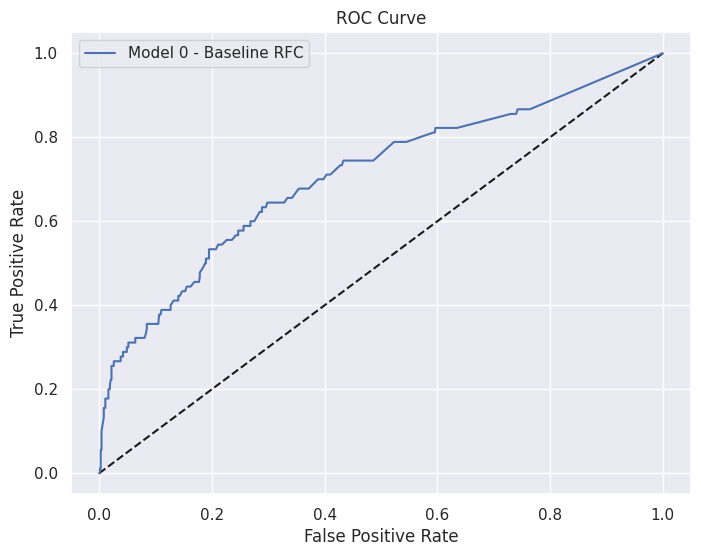

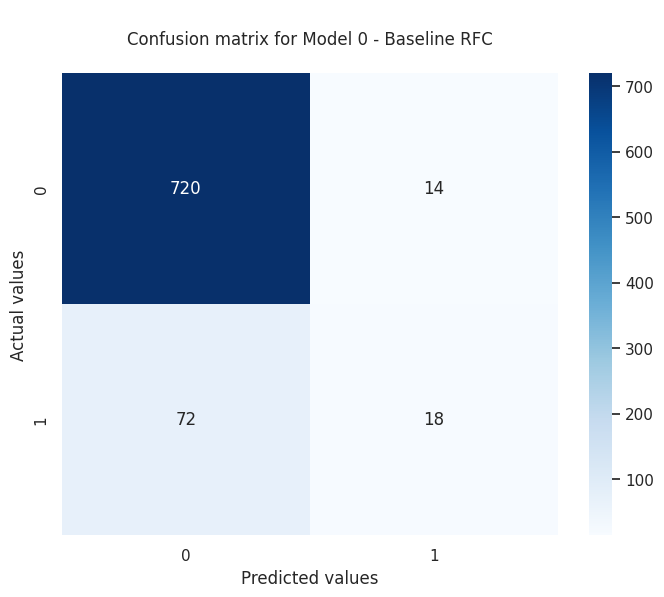

,Model,F1_score,AUC
0,Model 0 - Baseline RFC,0.295082,0.706668
1,Model 1 - Logistic Regression - dataset 1,0.443515,0.813896
2,Model 2 - Logistic Regression - dataset 2,0.380435,0.786088
3,Model 3 - Logistic Regression - dataset 3,0.390625,0.812791
4,Model 0 - Baseline RFC,0.295082,0.706668


In [401]:
sns.set(rc={"figure.figsize":(8, 6)})
calculation_metrics(rfc_pipeline, 'Model 0 - Baseline RFC')

In [ ]:
# stop

## Model 1 - Logistic Regression zestaw danych 1


* z użyciem zestawu danych nr 1 wraz SMOTE (oversampling danych - przeciwdziałanie niezbalansowaniu - widoczny słabe wyniki prognozy w mniej licznej klasie) - dodanie również StandardScaler() - celem jest sprawdzenie feature importance dla wskaźników finansowych


In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat),
        ('ordinal_transformer', ordinal_transformer, ord_feat),
        ('numeric_transformer', numeric_transformer, num_feat)
    ]
)

lr_pipeline = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model', LogisticRegression(random_state=seed))])

In [ ]:
lr_param_grid = {
    'smote__sampling_strategy': [ 'minority', 'all', 0.5, 0.8, 0.9],
    'smote__k_neighbors': [2, 3, 5],
    'lr_model__C': [0.001, 0.01, 0.1],
    'lr_model__penalty': ['l1', 'l2', 'none'],
    'lr_model__max_iter': [15, 25, 50],
}

In [ ]:
lr_model_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline,
                                       param_grid = lr_param_grid,
                                       scoring='f1_weighted',
                                      #  error_score='raise',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_gridsearch.fit(X_train, y_train)

In [ ]:
print('\nBest hyperparameter:', lr_model_gridsearch.best_params_)

In [ ]:
lr_model = lr_model_gridsearch.best_estimator_

In [ ]:
X_test_data = X_test
y_test = y_test

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model, 'Model 1 - Logistic Regression - dataset 1')

In [ ]:
# stop

### Sprawdzenie istotności cech na bazie Regresji Logistycznej - zestaw 1

In [ ]:
training_features = list(model_columns)
training_features.remove('y_numeric')

In [ ]:
training_features

In [ ]:
calculate_and_print_feature_importance(lr_model, training_features)

## Model 2 - Logistic Regression zestaw danych 2

In [ ]:
# Model 2 - Logistic Regression zestaw 2

# * z kolumną year oraz wybranym najważniejszym wskaźnikiem finansowym

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_2),
        ('ordinal_transformer', ordinal_transformer, ord_feat_2),
        ('numeric_transformer', numeric_transformer, num_feat_2)
    ]
)

lr_pipeline_2 = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model_2', LogisticRegression(random_state=seed))])

In [ ]:
lr_param_grid_2 = {
    'smote__sampling_strategy': [ 'minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors': [3, 4, 5],
    'lr_model_2__C': [0.001, 0.01, 0.1],
    'lr_model_2__penalty': ['l1', 'l2', 'none'],
    'lr_model_2__max_iter': [4, 8, 15, 25]
}

In [ ]:
lr_model_2_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline_2,
                                       param_grid = lr_param_grid_2,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_2_gridsearch.fit(X_train_2, y_train_2)

In [ ]:
print('\nBest hyperparameter:', lr_model_2_gridsearch.best_params_)

In [ ]:
lr_model_2 = lr_model_2_gridsearch.best_estimator_

In [ ]:
X_test_data = X_test_2
y_test_data = y_test_2

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_2, 'Model 2 - Logistic Regression - dataset 2')

In [ ]:
# stop

### Istotność cech Logistic Regression zestaw danych 2

In [ ]:
training_features_2 = list(model_columns_2)
training_features_2.remove('y_numeric')
training_features_2

In [ ]:
calculate_and_print_feature_importance(lr_model_2, training_features_2)

In [ ]:
# stop

## Model 3 - Logistic Regression zestaw danych 3

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_3),
        ('ordinal_transformer', ordinal_transformer, ord_feat_3),
        ('numeric_transformer', numeric_transformer, num_feat_3)
    ]
)

lr_pipeline_3 = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model_3', LogisticRegression(random_state=seed))])

In [ ]:
lr_param_grid_3 = {
    'smote__sampling_strategy': [ 'minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors': [3, 4, 5],
    'lr_model_3__C': [0.001, 0.01, 0.1],
    'lr_model_3__penalty': ['l1', 'l2', 'none'],
    'lr_model_3__max_iter': [25, 50, 100],
}

In [ ]:
lr_model_3_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline_3,
                                       param_grid = lr_param_grid_3,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_3_gridsearch.fit(X_train_3, y_train_3)

In [ ]:
print('\nBest hyperparameter:', lr_model_3_gridsearch.best_params_)

In [ ]:
lr_model_3 = lr_model_3_gridsearch.best_estimator_

In [ ]:
# X_test_data
# y_test_data

In [ ]:
X_test_data = X_test_3
y_test_data = y_test_3

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_3, 'Model 3 - Logistic Regression - dataset 3')

In [ ]:
# stop

### Istotność cech Logitic Regression zestaw 3

In [ ]:
training_features_3 = list(model_columns_3)
training_features_3.remove('y_numeric')
training_features_3

In [ ]:
calculate_and_print_feature_importance(lr_model_3, training_features_3)

## Model 4 - Logistic Regression zestaw danych 4

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_4),
        ('ordinal_transformer', ordinal_transformer, ord_feat_4),
        ('numeric_transformer', numeric_transformer, num_feat_4)
    ]
)

lr_4_pipeline = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model_4', LogisticRegression(random_state=seed))])

In [ ]:
lr_4_param_grid = {
    'smote__sampling_strategy': [ 'minority', 'all', 0.5, 0.8, 0.9],
    'smote__k_neighbors': [4, 5, 7],
    'lr_model_4__C': [0.001, 0.01, 0.1],
    'lr_model_4__penalty': ['l1', 'l4', 'none', 'elasticnet'],
    'lr_model_4__max_iter': [25, 50, 100],
}

In [ ]:
lr_model_gridsearch_4 = HalvingGridSearchCV(estimator = lr_4_pipeline,
                                       param_grid = lr_4_param_grid,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_gridsearch_4.fit(X_train_4, y_train_4)

In [ ]:
print('\nBest hyperparameter:', lr_model_gridsearch_4.best_params_)

In [ ]:
lr_model_4 = lr_model_gridsearch_4.best_estimator_

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_4, 'Model 4 - Logistic Regression - dataset 4')

### Istotność cech Logitic Regression zestaw 4

In [ ]:
training_features_4 = list(model_columns_4)
training_features_4.remove('y_numeric')

In [ ]:
training_features_4

In [ ]:
best_lr_4_model = lr_model_4_gridsearch.best_estimator_

In [ ]:
if isinstance(best_lr_model, Pipeline_imb):
    lr_model_4 = best_lr_4_model.named_steps['lr_model']

    coefficients = lr_model_4.coef_[0]

    feature_importances = np.abs(coefficients)

    feature_names = training_features_4

    feature_importance_dict = dict(zip(feature_names, feature_importances))


    lr_trained_sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

    for feature, importance in lr_trained_sorted_feature_importance:
        print(f"Feature: {feature}, Importance: {importance}")
else:
    print("The best estimator is not a LogisticRegression model within a pipeline.")

## Model 5 - Support Vector Classifier ()- zestaw 1

In [ ]:
data.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat),
        ('ordinal_transformer', ordinal_transformer, ord_feat),
        ('numeric_transformer', numeric_transformer, num_feat)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model', svm.SVC(probability=True))
])

In [ ]:
svm_param_grid = {
    'smote__sampling_strategy':
     ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors':
     [3, 5, 7],
    'svm_model__C':
     [0.01, 0.1, 1, 10],
    'svm_model__kernel':
     ['linear', 'rbf', 'poly'],
    'svm_model__gamma':
     ['scale', 0.01, 0.1, 1]
}

In [ ]:
svm_search = HalvingGridSearchCV(svm_pipeline,
                                 svm_param_grid,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search.fit(X_train, y_train)

In [ ]:
print('\nBest hyperparameter:', svm_search.best_params_)

In [ ]:
svm_model = svm_search.best_estimator_

In [ ]:
X_test_data = X_test
y_test_data = y_test

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model, 'Model 5 -Support Vector Classiffier - dataset 1')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(svm_model, X_test, y_test)
print(feature_importance)

## Model 6 - Support Vector Classifier () - zestaw 2

In [ ]:
data_2.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_2 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_2),
        ('ordinal_transformer', ordinal_transformer, ord_feat_2),
        ('numeric_transformer', numeric_transformer, num_feat_2)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_2', svm.SVC(probability=True))
])

In [ ]:
svm_param_grid_2 = {
    'smote__sampling_strategy':
     ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors':
     [3, 5, 7],
    'svm_model_2__C':
     [0.01, 0.1, 1, 10],
    'svm_model_2__kernel':
     ['linear', 'rbf', 'poly'],
    'svm_model_2__gamma':
     ['scale', 0.001, 0.1, 1]
}

In [ ]:
svm_search_2 = HalvingGridSearchCV(svm_pipeline_2,
                                 svm_param_grid_2,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_2.fit(X_train_2, y_train_2)

In [ ]:
print('\nBest hyperparameter:', svm_search_2.best_params_)

In [ ]:
svm_model_2 = svm_search_2.best_estimator_

In [ ]:
X_test_data = X_test_2
y_test_data = y_test_2

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_2, 'Model 6 - Support Vector Classiffier - dataset 2')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_2, X_test_2, y_test_2)
print(feature_importance)

## Model 7 - Support Vector Classifier () - zestaw 3

In [ ]:
data_3.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_3 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_3),
        ('ordinal_transformer', ordinal_transformer, ord_feat_3),
        ('numeric_transformer', numeric_transformer, num_feat_3)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_3', svm.SVC(probability=True))
])

In [ ]:
svm_param_grid_3 = {
    'smote__sampling_strategy':
     ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors':
     [3, 5, 7],
    'svm_model_3__C':
    [0.01, 0.1, 1, 10],
    'svm_model_3__kernel':
     ['linear', 'rbf', 'poly'],
    'svm_model_3__gamma':
     ['scale', 0.001, 0.1, 1]
}

In [ ]:
svm_search_3 = HalvingGridSearchCV(svm_pipeline_3,
                                 svm_param_grid_3,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_3.fit(X_train_3, y_train_3)

In [ ]:
print('\nBest hyperparameter:', svm_search_3.best_params_)

In [ ]:
svm_model_3 = svm_search_3.best_estimator_

In [ ]:
X_test_data = X_test_3
y_test_data = y_test_3

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_3, 'Model 7 - Support Vector Classiffier - dataset 3')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_3, X_test_3, y_test_3)
print(feature_importance)

## Model 8 - Support Vector Classifier - zestaw 4

In [ ]:
data_4.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_4 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_4),
        ('ordinal_transformer', ordinal_transformer, ord_feat_4),
        ('numeric_transformer', numeric_transformer, num_feat_4)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_4', svm.SVC(probability=True))
])


In [ ]:
svm_param_grid_4 = {
    'smote__sampling_strategy':
     ['minority', 'all', 0.3, 0.5],
    'smote__k_neighbors':
     [3, 5, 7],
    'svm_model_4__C':
    [0.01, 0.1, 1, 10],
    'svm_model_4__kernel':
     ['linear', 'rbf', 'poly'],
    'svm_model_4__gamma':
     ['scale', 0.001, 0.1, 1]
}

In [ ]:
svm_search_4 = HalvingGridSearchCV(svm_pipeline_4,
                                 svm_param_grid_4,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_4.fit(X_train_4, y_train_4)

In [ ]:
print('\nBest hyperparameter:', svm_search_4.best_params_)

In [ ]:
svm_model_4 = svm_search_4.best_estimator_

In [ ]:
X_test_data = X_test_4
y_test_data = y_test_4

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_4, 'Model 8 - Support Vector Classiffier - dataset 4')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_4, X_test_4, y_test_4)
print(feature_importance)

## Model 9 - XGBoost() - zestaw 1

In [ ]:
data.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat),
        ('ordinal_transformer', ordinal_transformer, ord_feat),
        ('numeric_transformer', numeric_transformer, num_feat)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model', XGBClassifier(verbosity=0))
])

In [ ]:
xgb_param_grid = {
    'smote__sampling_strategy':
     ['minority', 'all', 0.3, 0.5],
    'smote__k_neighbors':
     [3, 5, 7],
    'xgb_model__n_estimators': [50, 100, 150],
    'xgb_model__max_depth': [2, 18, 25],
    'xgb_model__learning_rate': [0.2, 0.1, 0.01],
    'xgb_model__gamma': [0.00001, 0.0001, 0.001]
}

In [ ]:
xgb_search = HalvingGridSearchCV(xgb_pipeline,
                                 xgb_param_grid,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search.fit(X_train, y_train)

In [ ]:
print('\nBest hyperparameters:', xgb_search.best_params_)
xgb_model = xgb_search.best_estimator_

In [ ]:
X_test_data = X_test
y_test_data = y_test

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model, 'Model 9 - XGBoost() - dataset 1')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model, X_test , y_test )
print(feature_importance)

## Model 10 - XGBoost() - zestaw 2

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_2 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_2),
        ('ordinal_transformer', ordinal_transformer, ord_feat_2),
        ('numeric_transformer', numeric_transformer, num_feat_2)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_2', XGBClassifier(verbosity=0))
])


In [ ]:
xgb_param_grid_2 = {
    'smote__sampling_strategy':
     ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors':
     [3, 5, 7],
    'xgb_model_2__n_estimators': [50, 100, 150],
    'xgb_model_2__max_depth': [3, 6, 12],
    'xgb_model_2__learning_rate': [0.1, 0.01, 0.001],
    'xgb_model_2__gamma': [0.0001, 0.001, 0.01]
}

In [ ]:
xgb_search_2 = HalvingGridSearchCV(xgb_pipeline_2,
                                 xgb_param_grid_2,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_2.fit(X_train_2, y_train_2)

In [ ]:
print('\nBest hyperparameters:', xgb_search_2.best_params_)

In [ ]:
xgb_model_2 = xgb_search_2.best_estimator_

In [ ]:
X_test_data = X_test_2
y_test_data = y_test_2

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_2, 'Model 10 - XGBoost() - dataset 2')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_2, X_test_2 , y_test_2 )
print(feature_importance)

## Model 11 - XGBoost() - zestaw 3

In [ ]:
data_3.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_3 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_3),
        ('ordinal_transformer', ordinal_transformer, ord_feat_3),
        ('numeric_transformer', numeric_transformer, num_feat_3)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_3', XGBClassifier(verbosity=0))
])

In [ ]:
xgb_param_grid_3 = {
    'smote__sampling_strategy':
     ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors':
     [3, 5, 7],
    'xgb_model_3__n_estimators': [100, 150, 200],
    'xgb_model_3__max_depth': [6, 12, 20],
    'xgb_model_3__learning_rate': [0.01, 0.001, 0.0001],
    'xgb_model_3__gamma': [0.001, 0.01, 0.1]
}

In [ ]:
xgb_search_3 = HalvingGridSearchCV(xgb_pipeline_3,
                                 xgb_param_grid_3,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_3.fit(X_train_3, y_train_3)

In [ ]:
print('\nBest hyperparameters:', xgb_search_3.best_params_)
xgb_model_3 = xgb_search_3.best_estimator_

In [ ]:
X_test_data = X_test_3
y_test_data = y_test_3

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_3, 'Model 11 - XGBoost() - dataset 3')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_3, X_test_3 , y_test_3)
print(feature_importance)

## Model 12 - XGBoost() - zestaw  4

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_4 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_4),
        ('ordinal_transformer', ordinal_transformer, ord_feat_4),
        ('numeric_transformer', numeric_transformer, num_feat_4)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_4', XGBClassifier(verbosity=0))
])

In [ ]:
xgb_param_grid_4 = {
    'smote__sampling_strategy':
     ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors':
     [3, 5, 7],
    'xgb_model_4__n_estimators': [50, 100, 150],
    'xgb_model_4__max_depth': [6, 12, 20],
    'xgb_model_4__learning_rate': [0.1, 0.01, 0.001],
    'xgb_model_4__gamma': [0.001, 0.01, 0.1]
}

In [ ]:
xgb_search_4 = HalvingGridSearchCV(xgb_pipeline_4,
                                 xgb_param_grid_4,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_4.fit(X_train_4, y_train_4)

In [ ]:
print('\nBest hyperparameters:', xgb_search_4.best_params_)
xgb_model_4 = xgb_search_4.best_estimator_

In [ ]:
X_test_data = X_test_4
y_test_data = y_test_4

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_4, 'Model 12 - XGBoost() - dataset_4')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_4, X_test_4 , y_test_4)
print(feature_importance)

## Model 13 - Logistic Regression zestaw danych 5

In [ ]:
data_5.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_5),
        ('ordinal_transformer', ordinal_transformer, ord_feat_5),
        ('numeric_transformer', numeric_transformer, num_feat_5)
    ]
)

lr_pipeline_5 = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model_5', LogisticRegression(random_state=seed))])

In [ ]:
lr_param_grid_5 = {
    'smote__sampling_strategy': ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors': [3, 4, 5],
    'lr_model_5__C': [0.001, 0.01, 0.1],
    'lr_model_5__penalty': [ 'l1', 'l2', 'none'],
    'lr_model_5__max_iter': [25, 50, 100],
}

In [ ]:
lr_model_5_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline_5,
                                       param_grid = lr_param_grid_5,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_5_gridsearch.fit(X_train_5, y_train_5)

In [ ]:
lr_model_5 = lr_model_5_gridsearch.best_estimator_

In [ ]:
X_test_data = X_test_5
y_test_data = y_test_5

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_5, 'Model 13 - Logistic Regression - dataset 5')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(lr_model_5, X_test_5 , y_test_5)
print(feature_importance)

## Model 14 - Support Vector Classifier - zestaw 5

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_5 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_5),
        ('ordinal_transformer', ordinal_transformer, ord_feat_5),
        ('numeric_transformer', numeric_transformer, num_feat_5)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_5', svm.SVC(probability=True, class_weight='balanced'))
])

In [ ]:
svm_param_grid_5 = {
    'smote__sampling_strategy':
     ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors':
     [ 4, 7, 12],
    'svm_model_5__C':
     [0.001, 0.01, 0.1, 1],
    'svm_model_5__kernel':
     ['linear', 'rbf', 'poly'],
    'svm_model_5__gamma':
     ['scale',0.0001, 0.001, 0.1]
}

In [ ]:
svm_search_5 = HalvingGridSearchCV(svm_pipeline_5,
                                 svm_param_grid_5,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_5.fit(X_train_5, y_train_5)

In [ ]:
print('\nBest hyperparameter:', svm_search_5.best_params_)

In [ ]:
svm_model_5 = svm_search_5.best_estimator_

In [ ]:
X_test_data = X_test_5
y_test_data = y_test_5

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_5, 'Model 14 - Support Vector Classiffier - dataset 5')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_5, X_test_5 , y_test_5)
print(feature_importance)

## Model 15 - XGBoost() - zestaw 5

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_5 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_5),
        ('ordinal_transformer', ordinal_transformer, ord_feat_5),
        ('numeric_transformer', numeric_transformer, num_feat_5)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_5', XGBClassifier(verbosity=0))
])


In [ ]:
xgb_param_grid_5 = {
    'smote__sampling_strategy': ['minority', 'all',  0.5, 0.8],
    'smote__k_neighbors': [5, 7, 10],
    'xgb_model_5__n_estimators': [50, 100, 150],
    'xgb_model_5__max_depth': [15, 20, 25],
    'xgb_model_5__learning_rate': [0.1, 0.01, 0.001],
    'xgb_model_5__gamma': [0.001, 0.01, 0.1, 0.3]
}

In [ ]:
xgb_search_5 = HalvingGridSearchCV(xgb_pipeline_5,
                                 xgb_param_grid_5,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_5.fit(X_train_5, y_train_5)

In [ ]:
print('\nBest hyperparameters:', xgb_search_5.best_params_)

In [ ]:
xgb_model_5 = xgb_search_5.best_estimator_

In [ ]:
X_test_data = X_test_5
y_test_data = y_test_5

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_5, 'Model 15 - XGBoost() - dataset_5')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_5, X_test_5 , y_test_5)
print(feature_importance)

# Wyniki zbiorcze

In [ ]:
top_5_auc_models = metrics_dataframe.sort_values(by=['AUC', 'F1_score'], ascending=False).head(7)
top_5_auc_models

In [ ]:
stop

In [ ]:
models = [lr_model_3, svm_model_3, svm_model, svm_model_4, lr_model]
model_names = top_5_auc_models['Model']

X_test_data_end = [X_test_3, X_test_3, X_test, X_test_4, X_test]
y_test_data_end = [y_test_3, y_test_3, y_test, y_test_4, y_test]

In [ ]:
plt.figure(figsize=(10, 6))

for model, model_name, X_testing, y_testing in zip(models, model_names, X_test_data_end, y_test_data_end):
    try:
        predictions_proba = model.predict_proba(X_testing)
        fpr, tpr, _ = roc_curve(y_testing, predictions_proba[:, 1])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} - AUC = {auc_score:.2f}')
    except Exception as e:
        print(f"An error occurred for model {model_name}: {str(e)}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Top 5 models')
plt.legend()
plt.show()